In [1]:
import os ; os.environ['OMP_NUM_THREADS'] = os.environ.get('OMP_NUM_THREADS', '1')
print('Parrallel:', int(os.environ.get('OMP_NUM_THREADS')) > 1)

Parrallel: False


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import frank
frank.enable_logging()

from gofish import imagecube

In [3]:
%matplotlib inline
%matplotlib notebook

In [4]:
plt.rcParams.update({'font.size': 14})

plt.rcParams.update({'axes.linewidth': 2.25})
plt.rcParams.update({'axes.labelpad': 5})

plt.rcParams.update({'xtick.major.size': 7.5})
plt.rcParams.update({'xtick.minor.size': 4.5})
plt.rcParams.update({'ytick.major.size': 7.5})
plt.rcParams.update({'ytick.minor.size': 4.5})

plt.rcParams.update({'xtick.major.width': 1.5})
plt.rcParams.update({'ytick.major.width': 1.5})
plt.rcParams.update({'xtick.minor.width': 1.5})
plt.rcParams.update({'ytick.minor.width': 1.5})

plt.rcParams.update({'xtick.major.pad': 5})
plt.rcParams.update({'ytick.major.pad': 5})

plt.rcParams.update({'xtick.top': True})
plt.rcParams.update({'ytick.right': True})
plt.rcParams.update({'xtick.labeltop': False})
plt.rcParams.update({'ytick.labelright': False})

plt.rcParams.update({'xtick.direction': "in"})
plt.rcParams.update({'ytick.direction': "in"})

In [5]:
def _calculate_flux_jy_sr(data,b_min,b_maj):
    """
    Convert brightness from Jy/beam to Jy/sr.
    ------------------------------------------------
    Parameters:
    b_maj, b_min: CLEAN beam (units: arcsec, arcsec)
    data:         intensity  (units: Jy/beam)
    ------------------------------------------------
    Return:
    data in Jy/sr
    """
    omega  = np.radians(b_min/3600.)
    omega *= np.radians(b_maj/3600.)
    
    beam_area = np.pi*omega/(4.*np.log(2.))
    
    return data/beam_area

ALMA band 7:

In [6]:
UVTABLE = 'uvtable_CI_Tau_B7.txt'

In [7]:
u, v, vis, w = frank.io.load_uvtable(UVTABLE)

  Loading UVTable


In [8]:
geom = frank.geometry.FitGeometryGaussian(inc_pa=(49.24,11.28))
geom.fit(u, v, vis, w)

    Fitting Gaussian to determine geometry (not fitting for inc or PA)


In [9]:
print('Fitted geometry: inc  = {:.2f} deg,\n\t\t PA   = {:.2f} deg,\n\t\t' 
      ' dRA  = {:.2e} mas,\n\t\t dDec = {:.2e} mas'.format(geom.inc, 
                                                           geom.PA,
                                                           geom.dRA*1e3,
                                                           geom.dDec*1e3))

Fitted geometry: inc  = 49.24 deg,
		 PA   = 11.28 deg,
		 dRA  = 4.75e-02 mas,
		 dDec = -8.36e-02 mas


In [10]:
geom = frank.geometry.FixedGeometry(49.24, 11.28, 4.75e-05, -8.36e-05)

In [11]:
up, vp, visp = geom.apply_correction(u, v, vis)

In [12]:
# Re-estimate weights:
# wp = frank.utilities.estimate_weights(up, vp, vis, use_median=True)

In [13]:
# Check that the fit worked well: you should expect no incl,pa,ra,dec:

geom_check = frank.geometry.FitGeometryGaussian(guess=[0,0,0,0])
geom_check.fit(up, vp, visp, w)

print('Fitted geometry: inc  = {:.2f} deg,\n\t\t PA   = {:.2f} deg,\n\t\t' 
      ' dRA  = {:.2e} mas,\n\t\t dDec = {:.2e} mas'.format(geom_check.inc, 
                                                           geom_check.PA,
                                                           geom_check.dRA*1e3,
                                                           geom_check.dDec*1e3))

    Fitting Gaussian to determine geometry


Fitted geometry: inc  = 0.00 deg,
		 PA   = 0.00 deg,
		 dRA  = 3.86e-02 mas,
		 dDec = -4.42e-02 mas


<IPython.core.display.Javascript object>


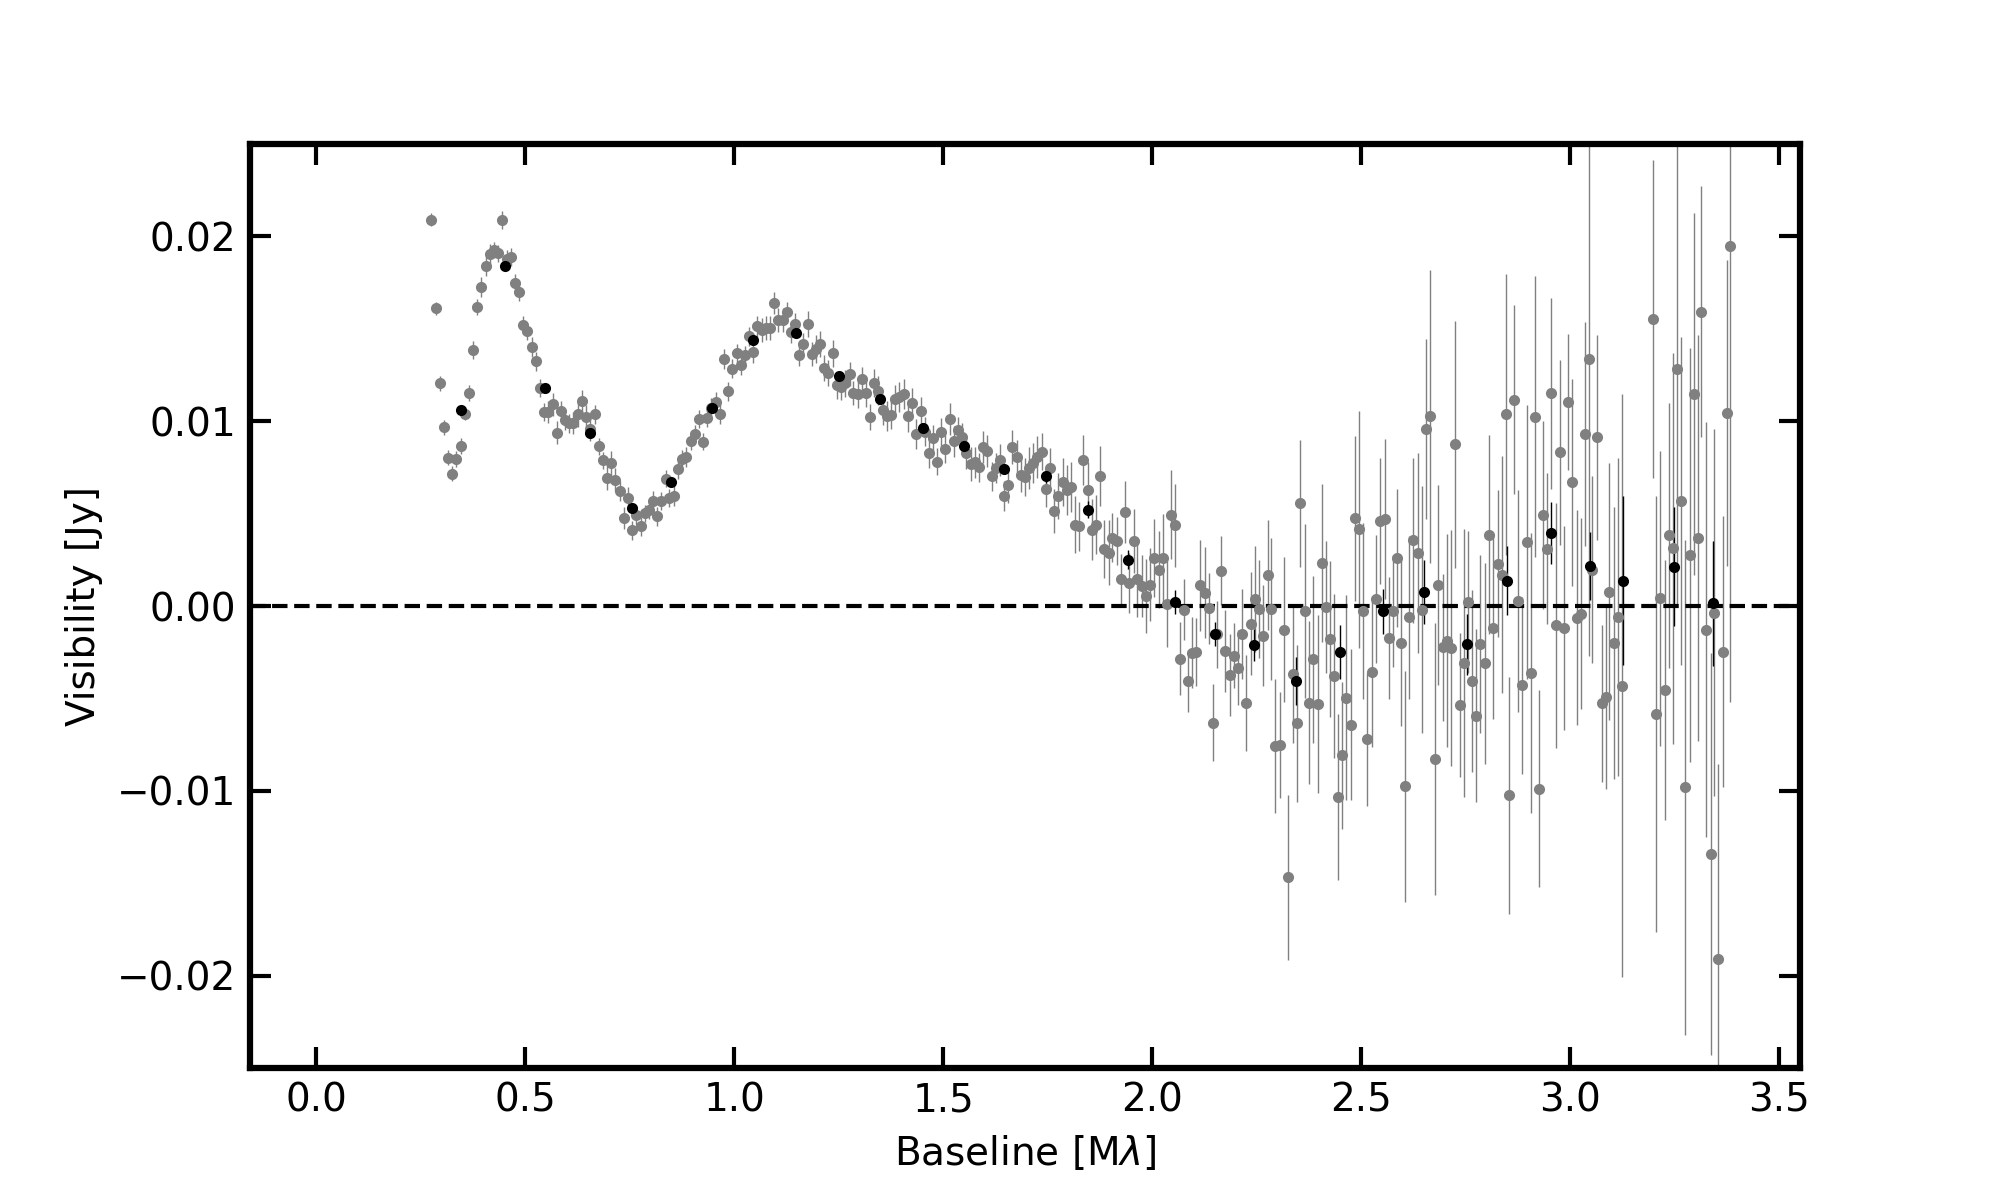

In [14]:
plt.figure(figsize=(10,6))

binned_vis = frank.utilities.UVDataBinner(np.hypot(up,vp), visp, w, 1e4)
plt.errorbar(binned_vis.uv/1e6, binned_vis.V.real, binned_vis.error.real, ls='none', lw=0.5, c='gray', marker='.')

binned_vis = frank.utilities.UVDataBinner(np.hypot(up,vp), visp, w, 1e5)
plt.errorbar(binned_vis.uv/1e6, binned_vis.V.real, binned_vis.error.real, ls='none', lw=0.5, c='k', marker='.')

plt.axhline(0, ls='--', c='k')

plt.xlabel(r'Baseline [M$\lambda$]')
plt.ylabel(r'Visibility [Jy]')

plt.xscale('linear')

plt.ylim(-2.5e-2,+2.5e-2)

plt.savefig('./band7/band7_vis.pdf',bbox_inches='tight')
plt.show()

In [15]:
N        = 400
Rmax     = 2.00
alpha    = 1.05
w_smooth = 1e+1
method   = 'LogNormal'

In [16]:
FF = frank.radial_fitters.FrankFitter(
    N              = N, 
    Rmax           = Rmax, 
    geometry       = geom, 
    method         = method,
    alpha          = alpha, 
    weights_smooth = w_smooth, 
    max_iter       = 4000
)

sol_B7 = FF.fit(u, v, vis, w)
#steps 423 alpha 1.05, wsmooth 1e+1, 400

  Assuming an optically thick model (the default): Scaling the total flux to account for the source inclination
  Fitting for brightness profile using FrankFitter: LogNormal method
    Building visibility matrices M and j


    FrankFitter iteration 423

    Convergence criterion met at iteration 423


<IPython.core.display.Javascript object>


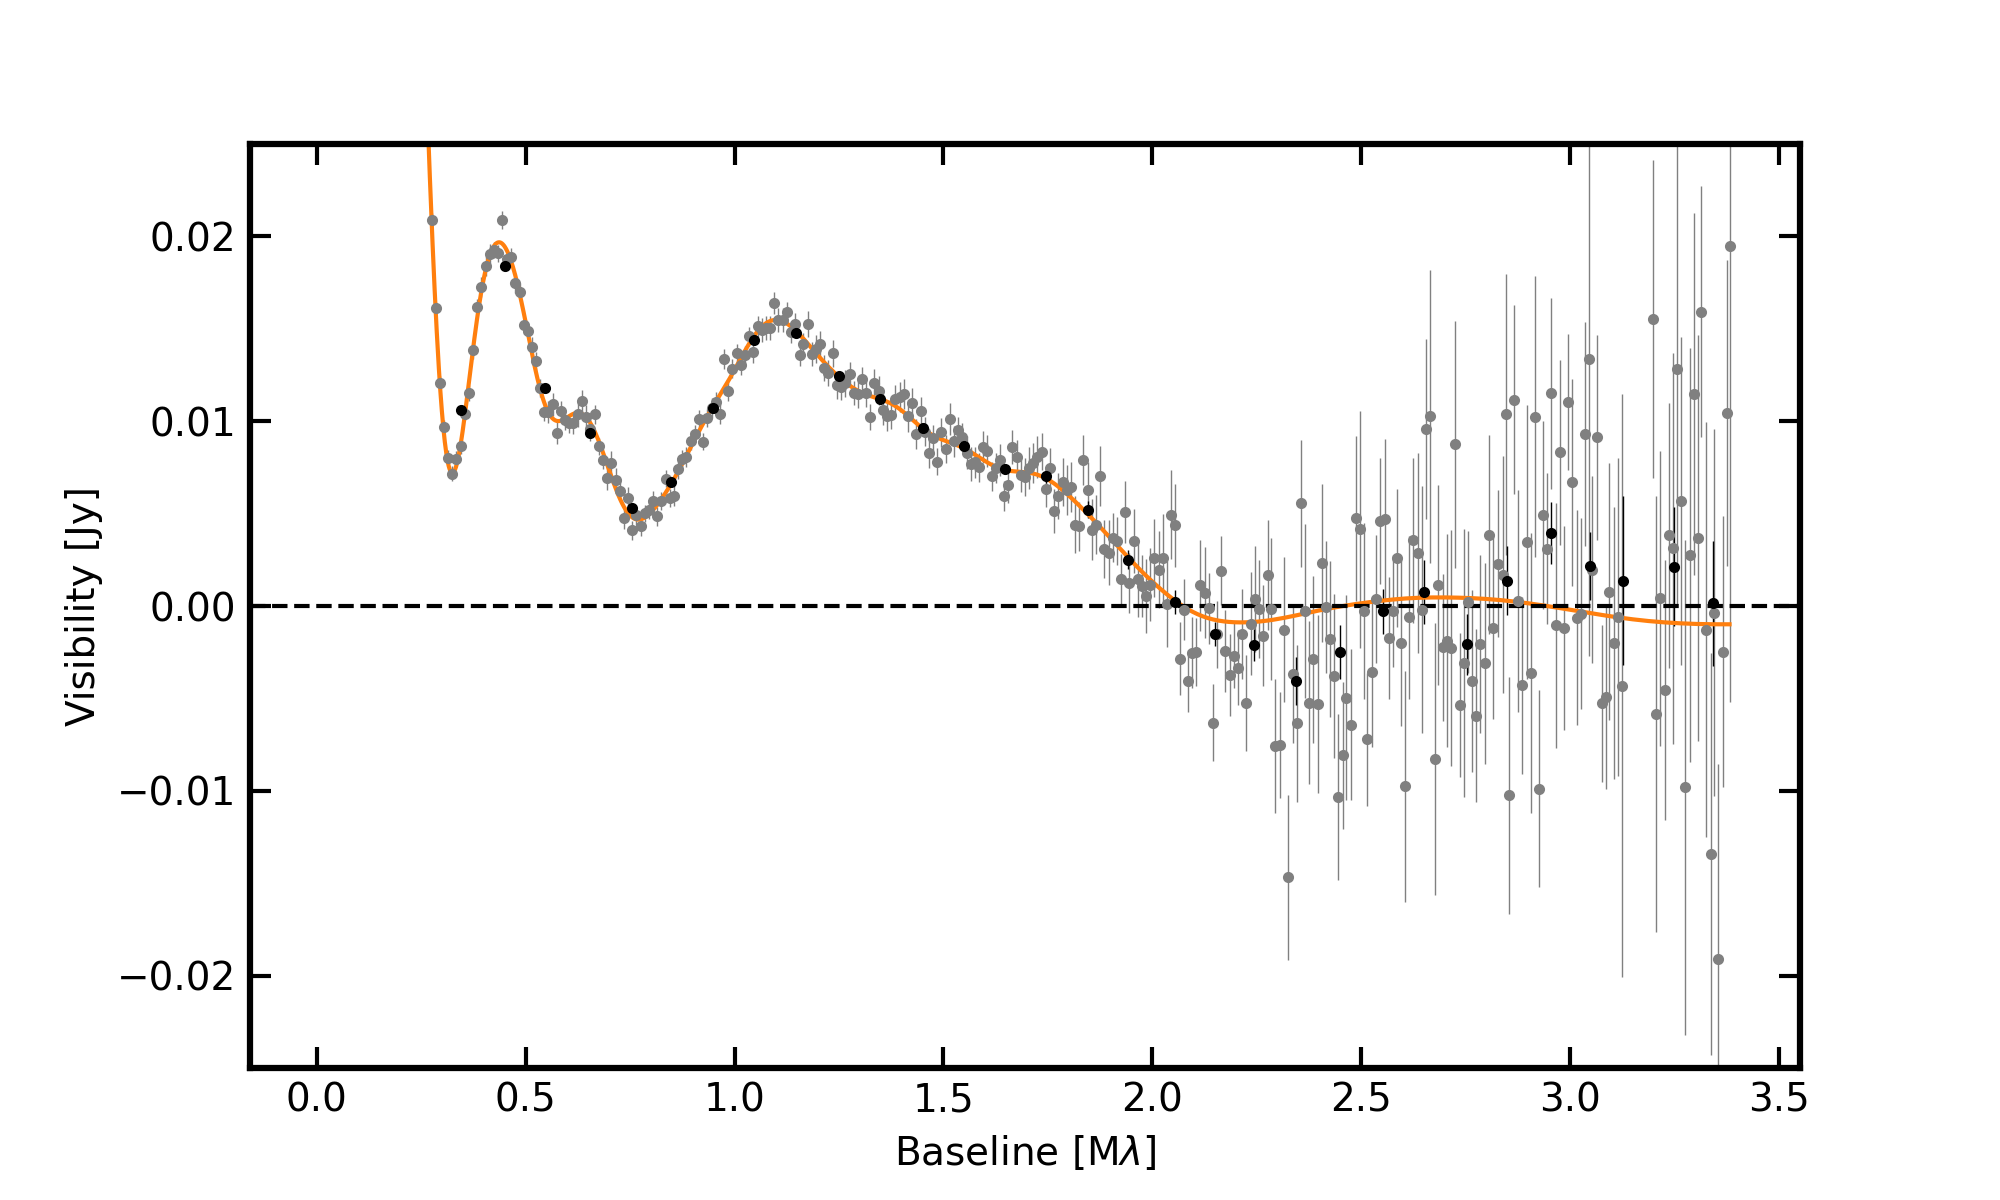

In [17]:
plt.figure(figsize=(10,6))

binned_vis = frank.utilities.UVDataBinner(np.hypot(up,vp), visp, w, 1e4)
plt.errorbar(binned_vis.uv/1e6, binned_vis.V.real, binned_vis.error.real, ls='none', lw=0.5, c='gray', marker='.')

binned_vis = frank.utilities.UVDataBinner(np.hypot(up,vp), visp, w, 1e5)
plt.errorbar(binned_vis.uv/1e6, binned_vis.V.real, binned_vis.error.real, ls='none', lw=0.5, c='k', marker='.')

qs = np.geomspace(np.hypot(up,vp).min(), np.hypot(up,vp).max(), 1000)
plt.semilogx(qs/1e6, sol_B7.predict_deprojected(qs), c='C1')

plt.axhline(0, ls='--', c='k')

plt.xlabel(r'Baseline [M$\lambda$]')
plt.ylabel(r'Visibility [Jy]')

plt.xscale('linear')

plt.ylim(-2.5e-2,+2.5e-2)

plt.savefig('./band7/band7_vis_fit_alpha{}_wsmooth{}_N{}_Rout{}.pdf'.format(alpha,w_smooth,N,Rmax),bbox_inches='tight')
plt.show()

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


<IPython.core.display.Javascript object>


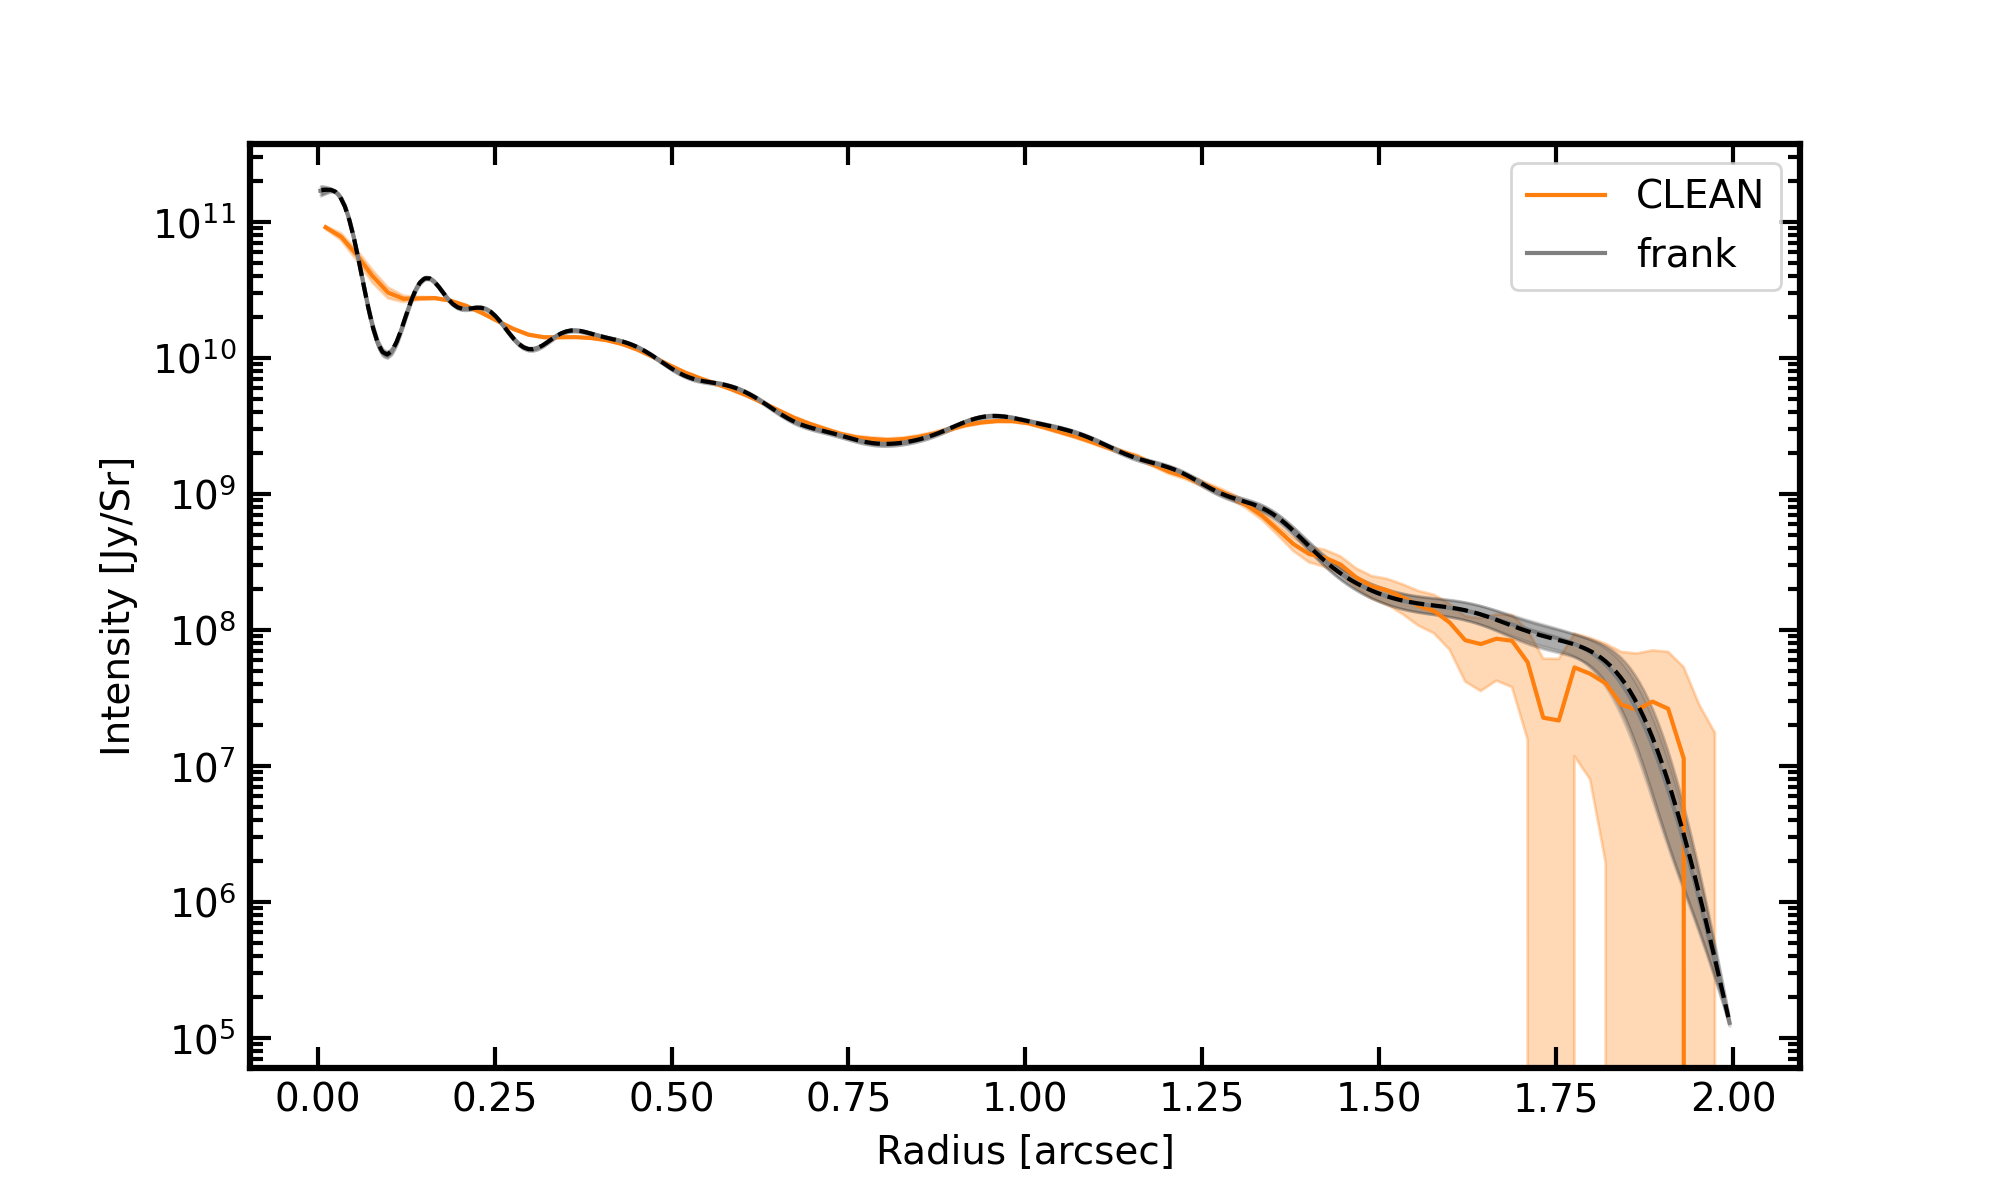

In [18]:
cube = imagecube('../../images_band7/CI_Tau_LB_-0.5robust_1.0sigma.image.tt0.fits', FOV=4.)

x, y, dy = cube.radial_profile(inc=geom.inc, PA=geom.PA)

y_b  = _calculate_flux_jy_sr( y, cube.bmin, cube.bmaj)
dy_b = _calculate_flux_jy_sr(dy, cube.bmin, cube.bmaj)

plt.figure(figsize=(10,6))

plt.semilogy(x, y_b, c='C1', label='CLEAN')
plt.fill_between(x, y_b - dy_b, y_b + dy_b, color='C1', alpha=0.3)

plt.semilogy(sol_B7.r, sol_B7.I, c='gray', label='frank')
err = sol_B7.I*np.sqrt(np.exp(np.diag(sol_B7.covariance)) - 1.)
plt.fill_between(sol_B7.r, sol_B7.I - err, sol_B7.I + err, alpha=0.3, color='gray')

plt.xlabel('Radius [arcsec]')
plt.ylabel('Intensity [Jy/Sr]')

plt.legend()

xf, yf, dy_f = np.loadtxt('../frankfits_06-2023/band7/CI_Tau_B7_frank_profile_bestfit.dat',unpack=True,skiprows=1)

l, = plt.plot(xf, yf, ls='--', c='k')
plt.fill_between(xf, yf - dy_f, yf + dy_f, color=l.get_color(), alpha=0.2)

plt.savefig('./band7/band7_vis_profile_fit_alpha{}_wsmooth{}_N{}_Rout{}.pdf'.format(alpha,w_smooth,N,Rmax),bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


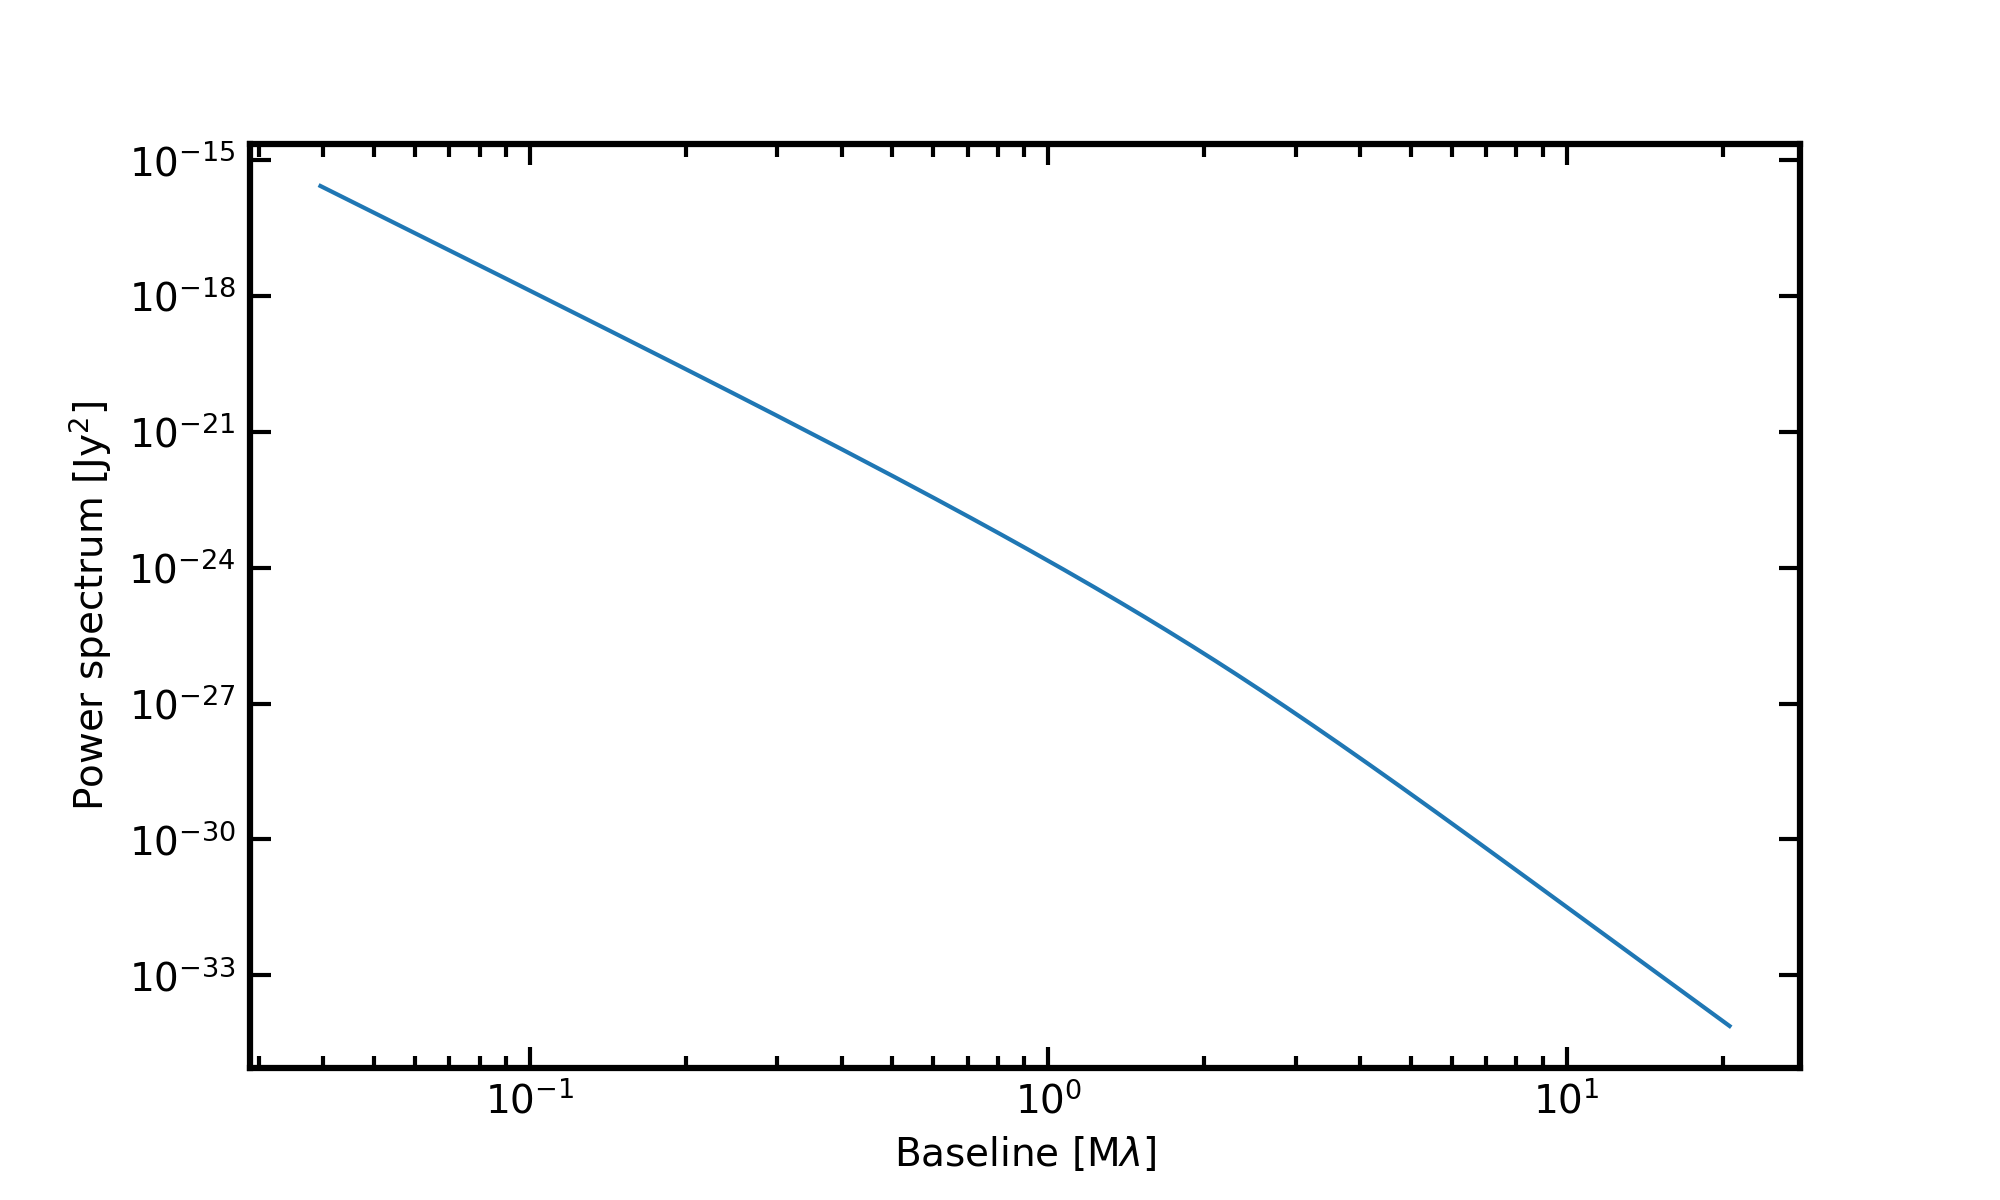

In [19]:
plt.figure(figsize=(10,6))

plt.loglog(sol_B7.q/1e6, sol_B7.power_spectrum)

plt.ylabel(r'Power spectrum [Jy$^2$]')
plt.xlabel(r'Baseline [M$\lambda$]')

plt.savefig('./band7/band7_pow_profile_fit_alpha{}_wsmooth{}_N{}_Rout{}.pdf'.format(alpha,w_smooth,N,Rmax),bbox_inches='tight')
plt.show()

In [20]:
frank.io.save_fit(
    u, v, vis, w, sol_B7, prefix='./band7/CI_Tau_B7', format='txt',
    save_solution       = True, 
    save_profile_fit    = True, 
    save_vis_fit        = True, 
    save_uvtables       = True,
    save_iteration_diag = True, 
    iteration_diag      = None,
)

  Saving fit results to ./band7/CI_Tau_B7*
    Saving fit and residual UVTables. N.B.: These will be of comparable size to your input UVTable


In [21]:
np.savetxt(
    './band7/CI_Tau_B7_frank_profile_bestfit.dat',
    np.array([sol_B7.r, sol_B7.I, err]).T,
    header='r [arcsec]\tI [Jy/sr]\tI_uncer [Jy/sr]'
)

np.savetxt(
    './band7/CI_Tau_B7_frank_visibilities_bestfit.dat',
    np.array([qs, sol_B7.predict_deprojected(qs)]).T,
    header='Deprojected baseline [lam]\tVisibility [Jy]'
)

ALMA band 6:

In [22]:
UVTABLE = 'uvtable_CI_Tau_B6_statwt_onechannel.txt'

In [23]:
u, v, vis, w = frank.io.load_uvtable(UVTABLE)

  Loading UVTable


In [24]:
geom = frank.geometry.FitGeometryGaussian(inc_pa=(49.24,11.28))
geom.fit(u, v, vis, w)

    Fitting Gaussian to determine geometry (not fitting for inc or PA)


In [25]:
print('Fitted geometry: inc  = {:.2f} deg,\n\t\t PA   = {:.2f} deg,\n\t\t' 
      ' dRA  = {:.2e} mas,\n\t\t dDec = {:.2e} mas'.format(geom.inc, 
                                                           geom.PA,
                                                           geom.dRA*1e3,
                                                           geom.dDec*1e3))

Fitted geometry: inc  = 49.24 deg,
		 PA   = 11.28 deg,
		 dRA  = 1.99e+00 mas,
		 dDec = 1.52e+00 mas


In [26]:
geom = frank.geometry.FixedGeometry(49.24, 11.28, 1.99e-03, 1.52e-03)

In [27]:
up, vp, visp = geom.apply_correction(u, v, vis)

In [28]:
# Re-estimate weights:
# wp = frank.utilities.estimate_weights(up, vp, vis, use_median=True)

In [29]:
# Check that the fit worked well: you should expect no incl,pa,ra,dec:

geom_check = frank.geometry.FitGeometryGaussian(guess=[0,0,0,0])
geom_check.fit(up, vp, visp, w)

print('Fitted geometry: inc  = {:.2f} deg,\n\t\t PA   = {:.2f} deg,\n\t\t' 
      ' dRA  = {:.2e} mas,\n\t\t dDec = {:.2e} mas'.format(geom_check.inc, 
                                                           geom_check.PA,
                                                           geom_check.dRA*1e3,
                                                           geom_check.dDec*1e3))

    Fitting Gaussian to determine geometry


Fitted geometry: inc  = 0.00 deg,
		 PA   = 0.00 deg,
		 dRA  = 8.76e-03 mas,
		 dDec = 1.11e-02 mas


<IPython.core.display.Javascript object>


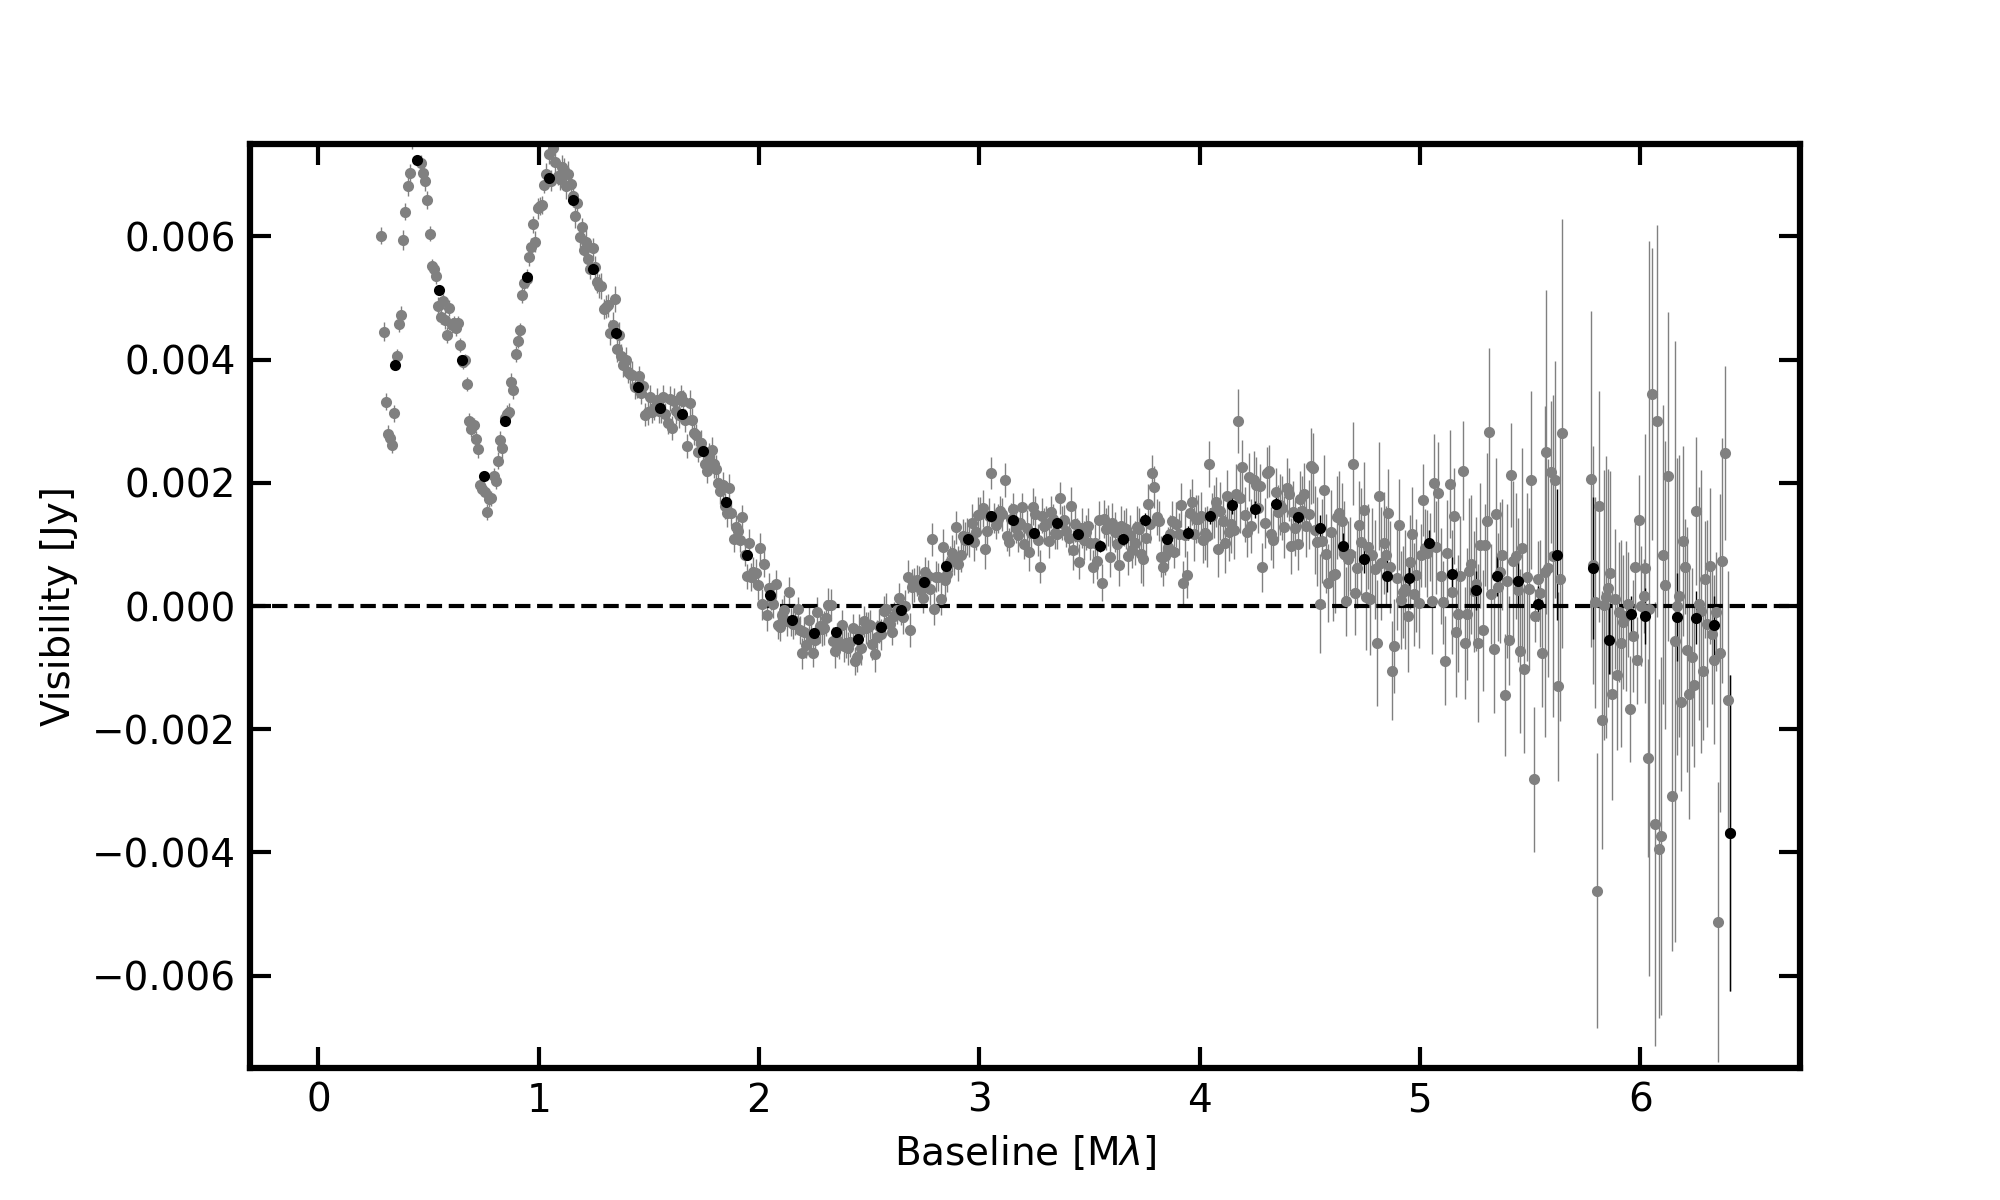

In [30]:
plt.figure(figsize=(10,6))

binned_vis = frank.utilities.UVDataBinner(np.hypot(up,vp), visp, w, 1e4)
plt.errorbar(binned_vis.uv/1e6, binned_vis.V.real, binned_vis.error.real, ls='none', lw=0.5, c='gray', marker='.')

binned_vis = frank.utilities.UVDataBinner(np.hypot(up,vp), visp, w, 1e5)
plt.errorbar(binned_vis.uv/1e6, binned_vis.V.real, binned_vis.error.real, ls='none', lw=0.5, c='k', marker='.')

plt.axhline(0, ls='--', c='k')

plt.xlabel(r'Baseline [M$\lambda$]')
plt.ylabel(r'Visibility [Jy]')

plt.xscale('linear')

plt.ylim(-7.5e-3,+7.5e-3)

plt.savefig('./band6/band6_vis.pdf',bbox_inches='tight')
plt.show()

In [31]:
N        = 500
Rmax     = 2.00
alpha    = 1.50
w_smooth = 1e+2
method   = 'LogNormal'

In [32]:
FF = frank.radial_fitters.FrankFitter(
    N              = N, 
    Rmax           = Rmax, 
    geometry       = geom, 
    method         = method,
    alpha          = alpha, 
    weights_smooth = w_smooth, 
    max_iter       = 4000
)

sol_B6 = FF.fit(u, v, vis, w)
#steps 51 alpha 1.50, wsmooth 1e+2, 500

  Assuming an optically thick model (the default): Scaling the total flux to account for the source inclination
  Fitting for brightness profile using FrankFitter: LogNormal method
    Building visibility matrices M and j


    FrankFitter iteration 51

    Convergence criterion met at iteration 51


<IPython.core.display.Javascript object>


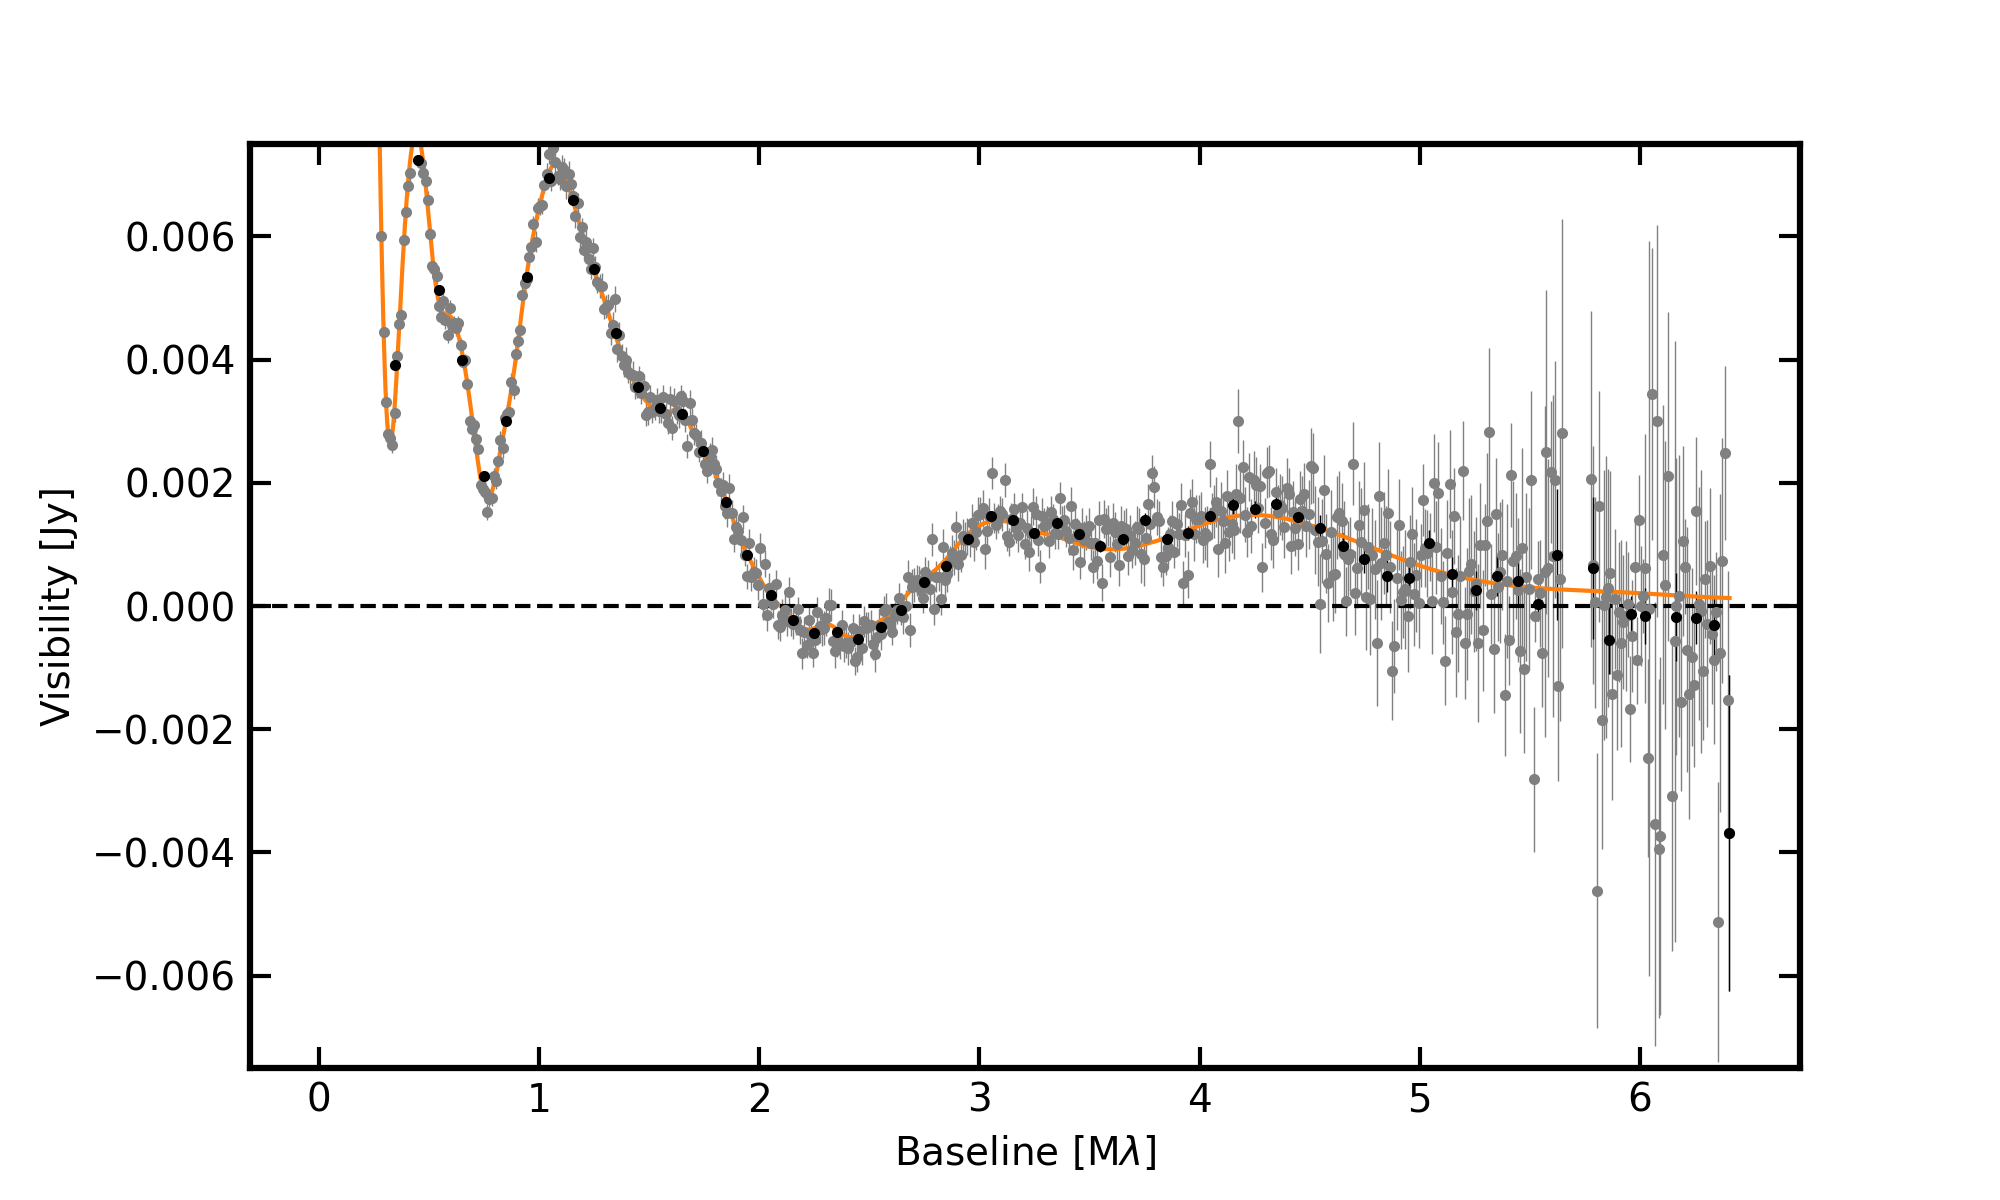

In [33]:
plt.figure(figsize=(10,6))

binned_vis = frank.utilities.UVDataBinner(np.hypot(up,vp), visp, w, 1e4)
plt.errorbar(binned_vis.uv/1e6, binned_vis.V.real, binned_vis.error.real, ls='none', lw=0.5, c='gray', marker='.')

binned_vis = frank.utilities.UVDataBinner(np.hypot(up,vp), visp, w, 1e5)
plt.errorbar(binned_vis.uv/1e6, binned_vis.V.real, binned_vis.error.real, ls='none', lw=0.5, c='k', marker='.')

qs = np.geomspace(np.hypot(up,vp).min(), np.hypot(up,vp).max(), 1000)
plt.semilogx(qs/1e6, sol_B6.predict_deprojected(qs), c='C1')

plt.axhline(0, ls='--', c='k')

plt.xlabel(r'Baseline [M$\lambda$]')
plt.ylabel(r'Visibility [Jy]')

plt.xscale('linear')

plt.ylim(-7.5e-3,+7.5e-3)

plt.savefig('./band6/band6_vis_fit_alpha{}_wsmooth{}_N{}_Rout{}.pdf'.format(alpha,w_smooth,N,Rmax),bbox_inches='tight')
plt.show()

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


<IPython.core.display.Javascript object>


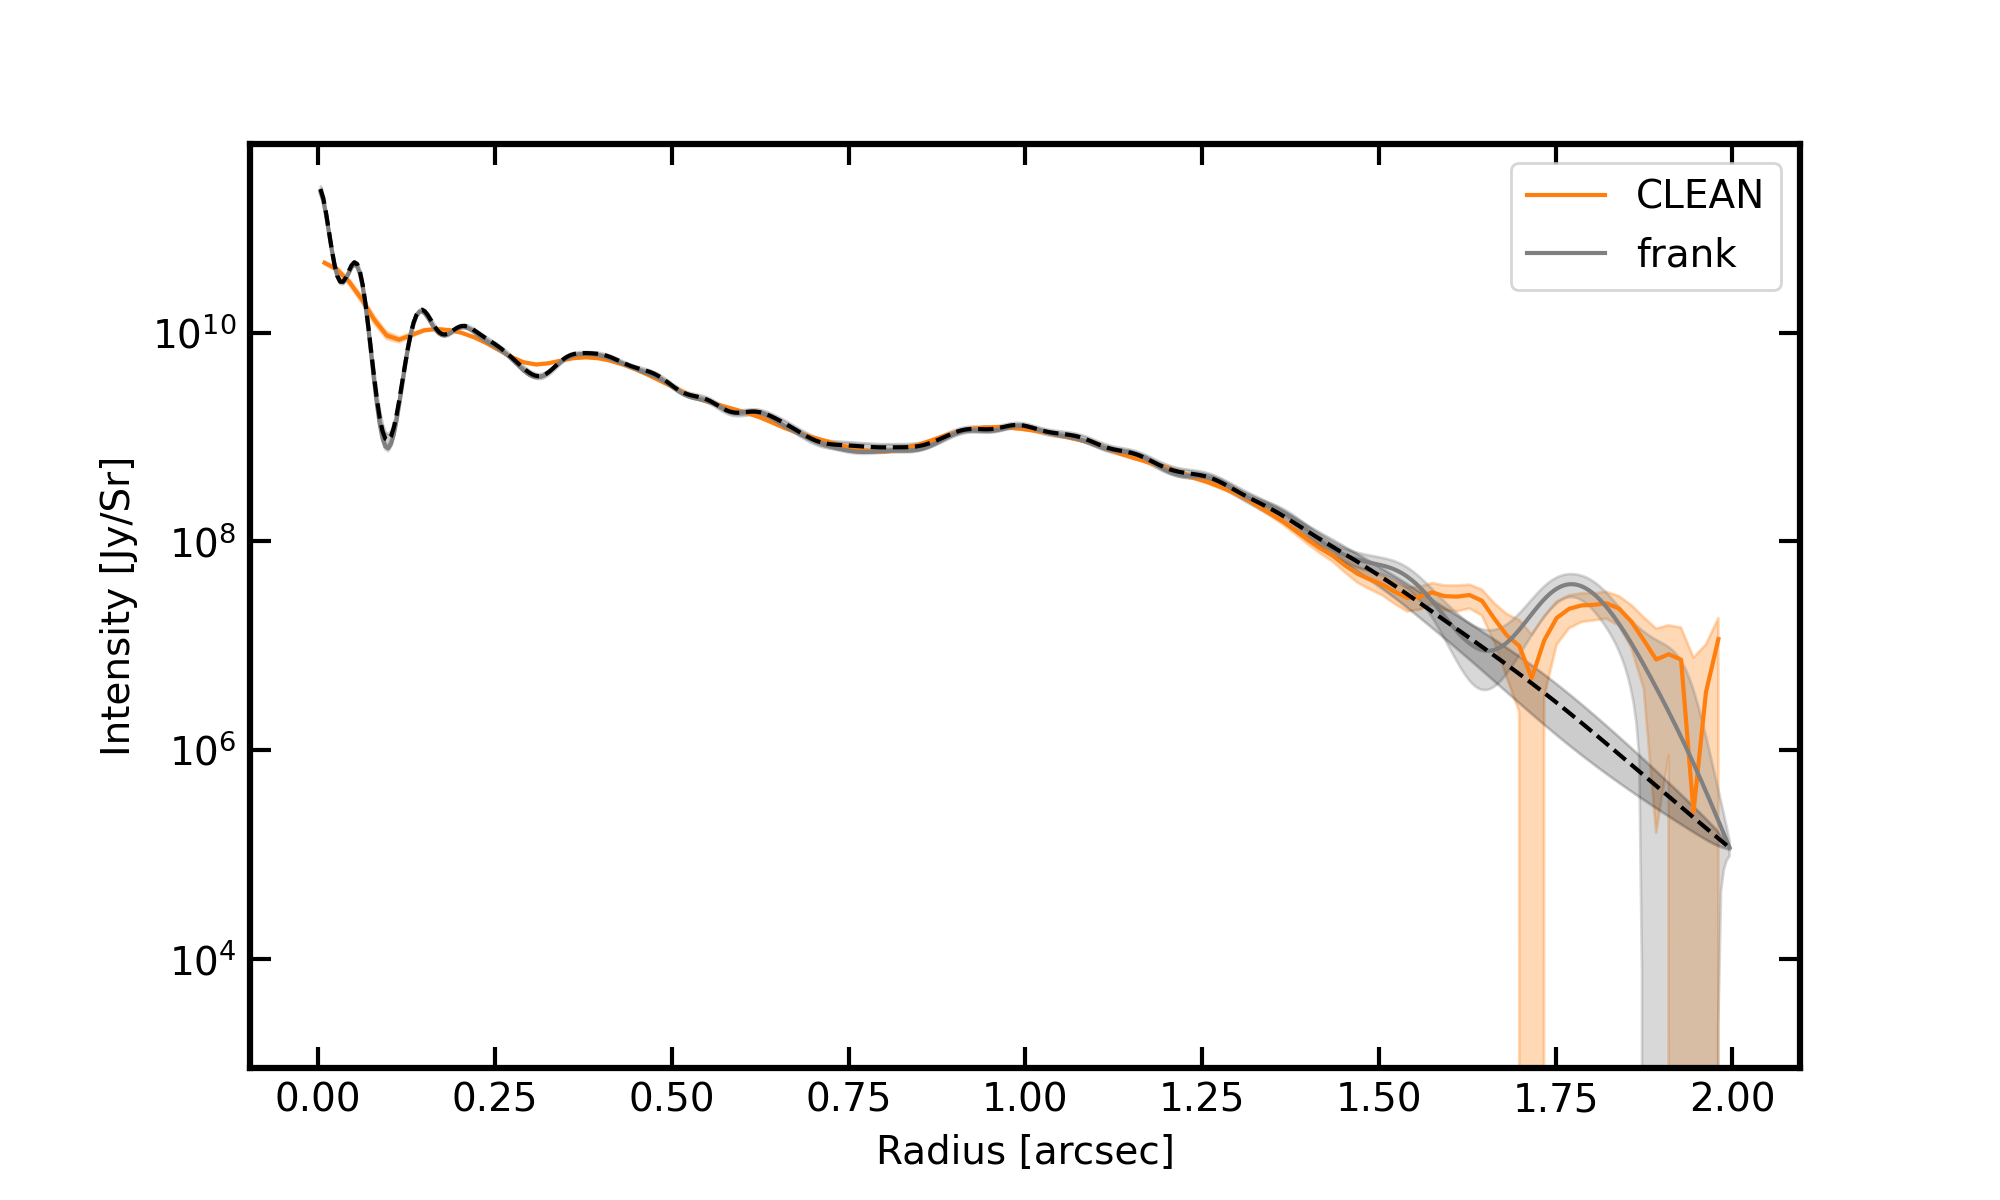

In [34]:
cube = imagecube('../../images_band6/CI_Tau_LB_1.5robust_1.0sigma.image.tt0.fits', FOV=4.)

x, y, dy = cube.radial_profile(inc=geom.inc, PA=geom.PA)

y_b  = _calculate_flux_jy_sr( y, cube.bmin, cube.bmaj)
dy_b = _calculate_flux_jy_sr(dy, cube.bmin, cube.bmaj)

plt.figure(figsize=(10,6))

plt.semilogy(x, y_b, c='C1', label='CLEAN')
plt.fill_between(x, y_b - dy_b, y_b + dy_b, color='C1', alpha=0.3)

plt.semilogy(sol_B6.r, sol_B6.I, c='gray', label='frank')
err = sol_B6.I*np.sqrt(np.exp(np.diag(sol_B6.covariance)) - 1.)
plt.fill_between(sol_B6.r, sol_B6.I - err, sol_B6.I + err, alpha=0.3, color='gray')

plt.xlabel('Radius [arcsec]')
plt.ylabel('Intensity [Jy/Sr]')

plt.legend()

xf, yf, dy_f = np.loadtxt('../frankfits_06-2023/band6_rescale_weights(discard)/CI_Tau_B6_frank_profile_bestfit.dat',unpack=True,skiprows=1)

l, = plt.plot(xf, yf*1.1, ls='--', c='k')
plt.fill_between(xf, (yf - dy_f)*1.1, (yf + dy_f)*1.1, color=l.get_color(), alpha=0.2)

plt.savefig('./band6/band6_vis_profile_fit_alpha{}_wsmooth{}_N{}_Rout{}.pdf'.format(alpha,w_smooth,N,Rmax),bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


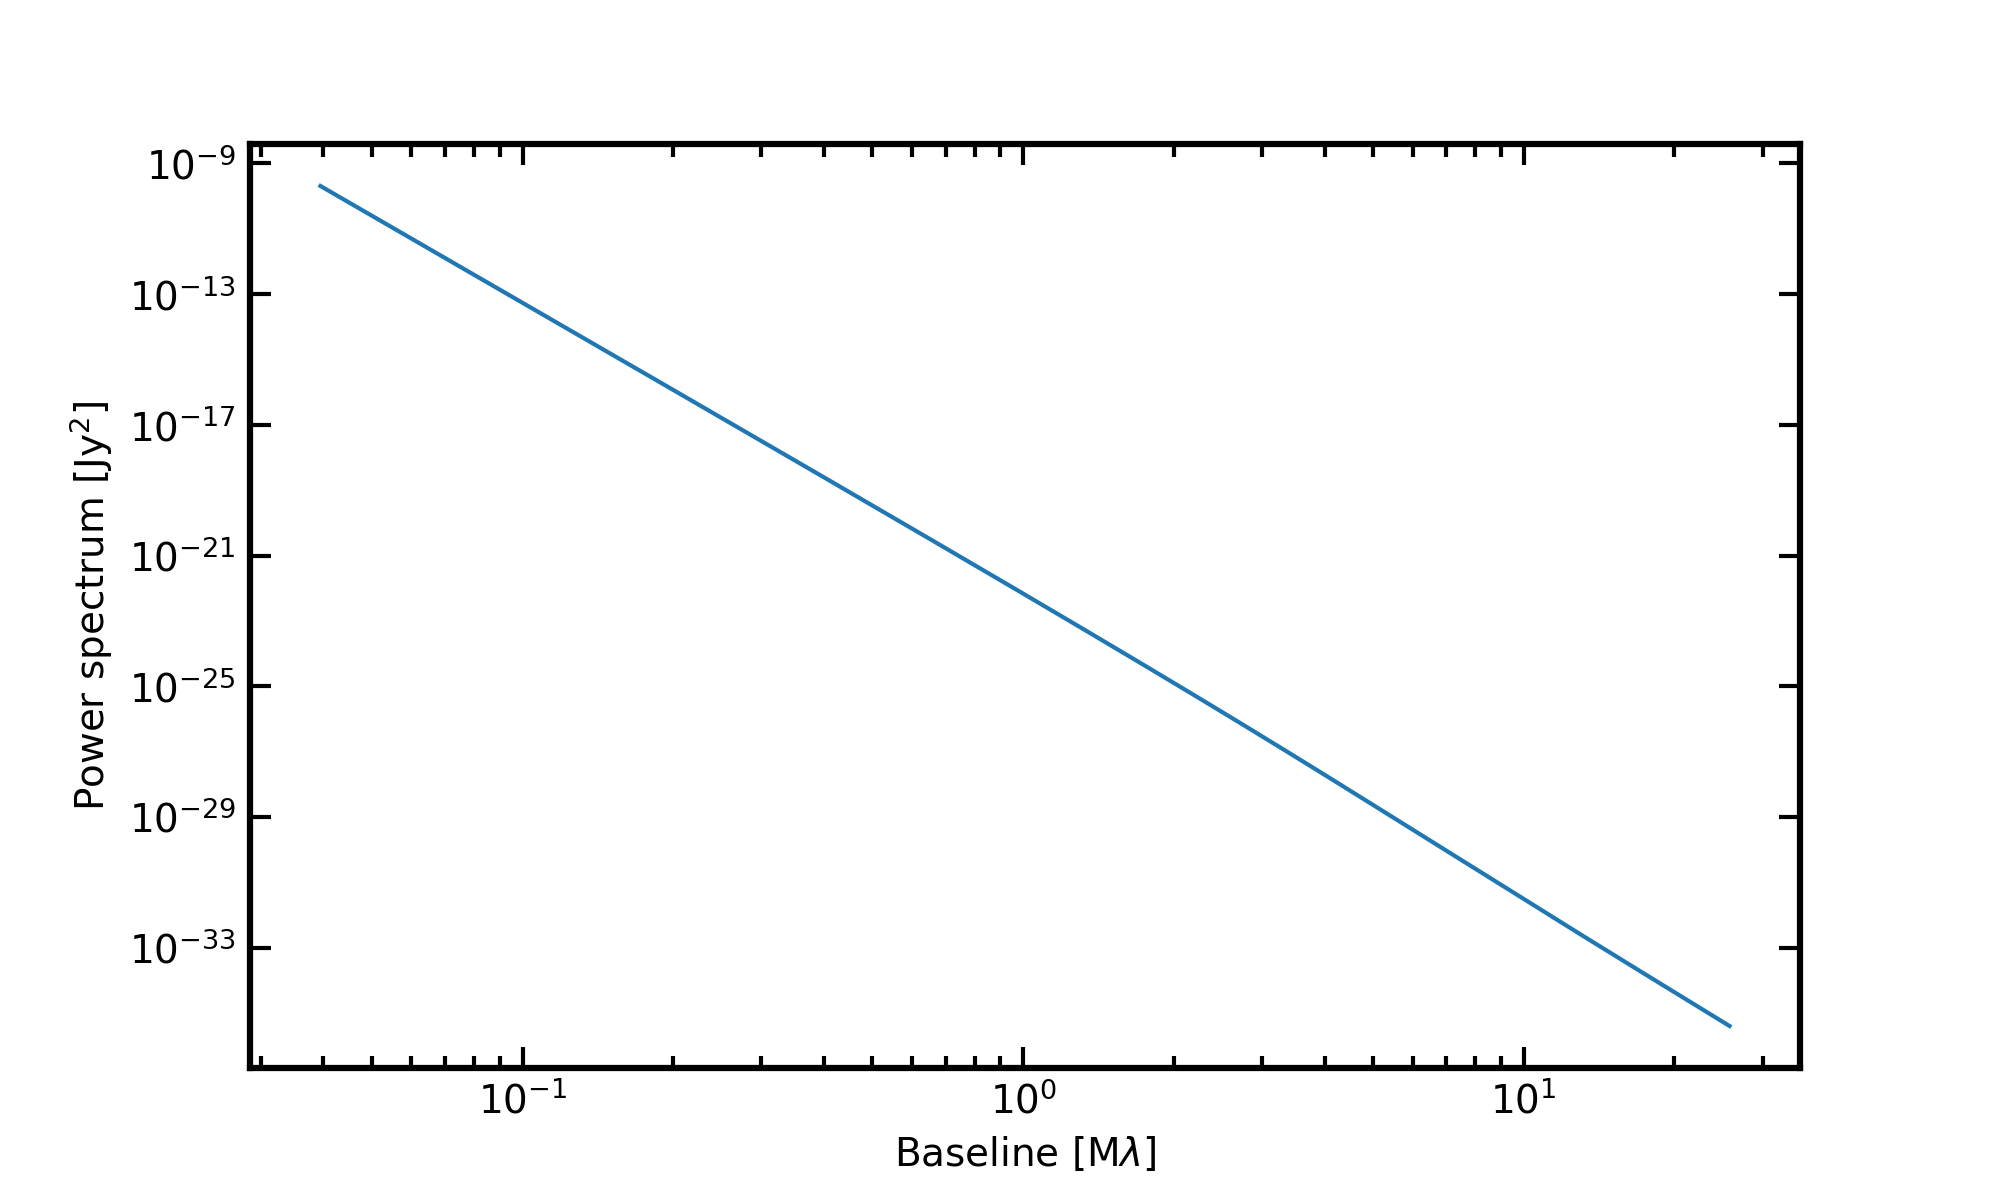

In [35]:
plt.figure(figsize=(10,6))

plt.loglog(sol_B6.q/1e6, sol_B6.power_spectrum)

plt.ylabel(r'Power spectrum [Jy$^2$]')
plt.xlabel(r'Baseline [M$\lambda$]')

plt.savefig('./band6/band6_pow_profile_fit_alpha{}_wsmooth{}_N{}_Rout{}.pdf'.format(alpha,w_smooth,N,Rmax),bbox_inches='tight')
plt.show()

In [36]:
frank.io.save_fit(
    u, v, vis, w, sol_B6, prefix='./band6/CI_Tau_B6', format='txt',
    save_solution       = True, 
    save_profile_fit    = True, 
    save_vis_fit        = True, 
    save_uvtables       = True,
    save_iteration_diag = True, 
    iteration_diag      = None,
)

  Saving fit results to ./band6/CI_Tau_B6*
    Saving fit and residual UVTables. N.B.: These will be of comparable size to your input UVTable


In [37]:
np.savetxt(
    './band6/CI_Tau_B6_frank_profile_bestfit.dat',
    np.array([sol_B6.r, sol_B6.I, err]).T,
    header='r [arcsec]\tI [Jy/sr]\tI_uncer [Jy/sr]'
)

np.savetxt(
    './band6/CI_Tau_B6_frank_visibilities_bestfit.dat',
    np.array([qs, sol_B6.predict_deprojected(qs)]).T,
    header='Deprojected baseline [lam]\tVisibility [Jy]'
)

ALMA band 3:

In [38]:
UVTABLE = './uvtable_CI_Tau_B3_PSsub.txt'

In [39]:
u, v, vis, w = frank.io.load_uvtable(UVTABLE)

  Loading UVTable


In [40]:
geom = frank.geometry.FitGeometryGaussian(inc_pa=(49.24,11.28))
geom.fit(u, v, vis, w)

    Fitting Gaussian to determine geometry (not fitting for inc or PA)


In [41]:
print('Fitted geometry: inc  = {:.2f} deg,\n\t\t PA   = {:.2f} deg,\n\t\t' 
      ' dRA  = {:.2e} mas,\n\t\t dDec = {:.2e} mas'.format(geom.inc, 
                                                           geom.PA,
                                                           geom.dRA*1e3,
                                                           geom.dDec*1e3))

Fitted geometry: inc  = 49.24 deg,
		 PA   = 11.28 deg,
		 dRA  = 5.70e-01 mas,
		 dDec = -1.12e+00 mas


In [42]:
geom = frank.geometry.FixedGeometry(49.24, 11.28, 5.88e-04, -1.14e-03)
#use the same deprojection params of ./psB3.ipynb

In [43]:
up, vp, visp = geom.apply_correction(u, v, vis)

In [44]:
# Re-estimate weights:
# wp = frank.utilities.estimate_weights(up, vp, vis, use_median=True)

<IPython.core.display.Javascript object>


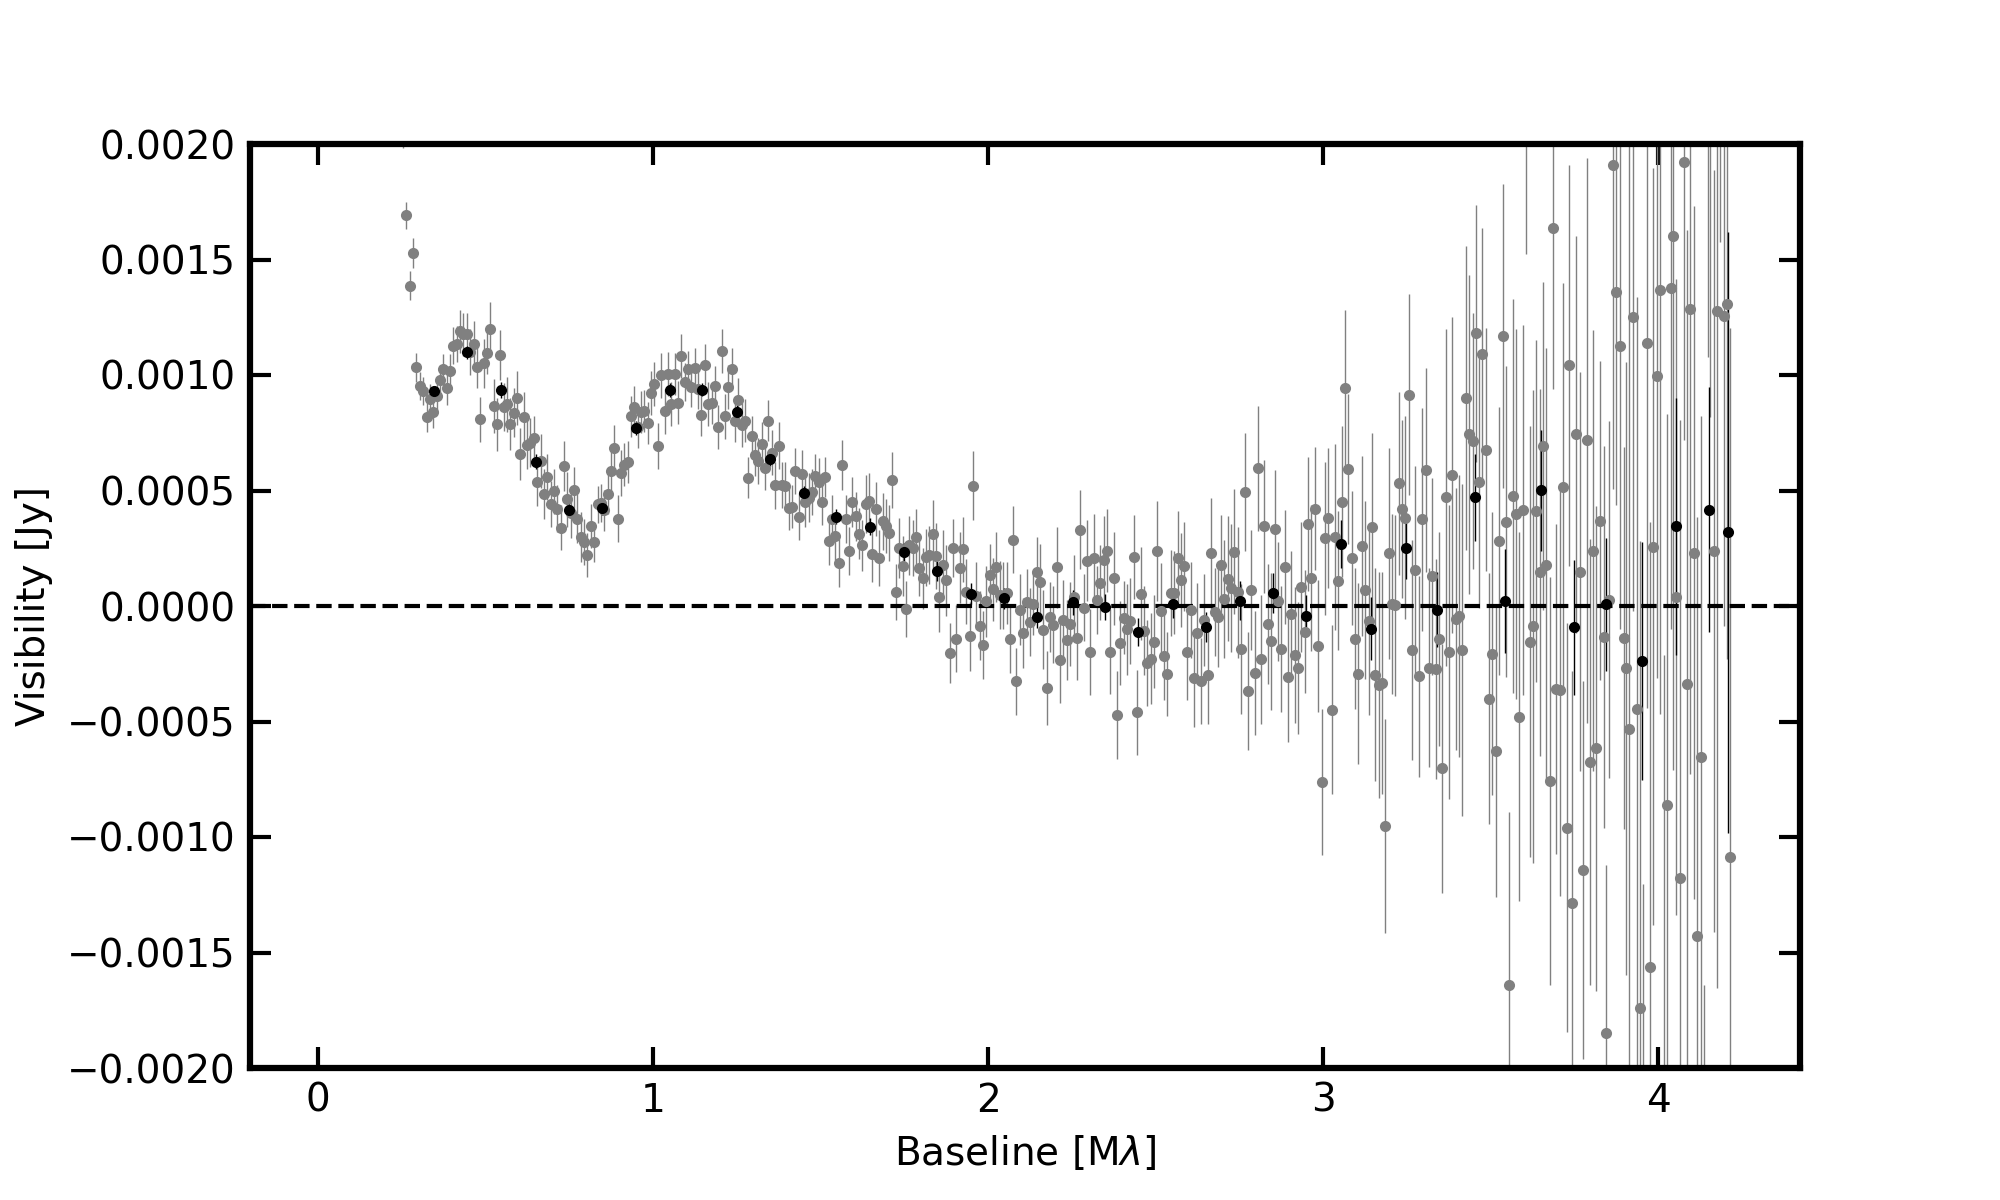

In [45]:
plt.figure(figsize=(10,6))

binned_vis = frank.utilities.UVDataBinner(np.hypot(up,vp), visp, w, 1e4)
plt.errorbar(binned_vis.uv/1e6, binned_vis.V.real, binned_vis.error.real, ls='none', lw=0.5, c='gray', marker='.')

binned_vis = frank.utilities.UVDataBinner(np.hypot(up,vp), visp, w, 1e5)
plt.errorbar(binned_vis.uv/1e6, binned_vis.V.real, binned_vis.error.real, ls='none', lw=0.5, c='k', marker='.')

plt.axhline(0, ls='--', c='k')

plt.xlabel(r'Baseline [M$\lambda$]')
plt.ylabel(r'Visibility [Jy]')

plt.xscale('linear')

plt.ylim(-2e-3,+2e-3)

plt.savefig('./band3_pssub/band3_vis.pdf',bbox_inches='tight')
plt.show()

In [46]:
N        = 400
Rmax     = 2.00
alpha    = 1.05
w_smooth = 1e-3
method   = 'LogNormal'

In [47]:
FF = frank.radial_fitters.FrankFitter(
    N              = N, 
    Rmax           = Rmax, 
    geometry       = geom, 
    method         = method,
    alpha          = alpha, 
    weights_smooth = w_smooth, 
    max_iter       = 4000
)

sol_B3 = FF.fit(u, v, vis, w)
#steps 659 alpha 1.05, wsmooth 1e-3, 400

  Assuming an optically thick model (the default): Scaling the total flux to account for the source inclination
  Fitting for brightness profile using FrankFitter: LogNormal method
    Building visibility matrices M and j


    FrankFitter iteration 659

    Convergence criterion met at iteration 659


<IPython.core.display.Javascript object>


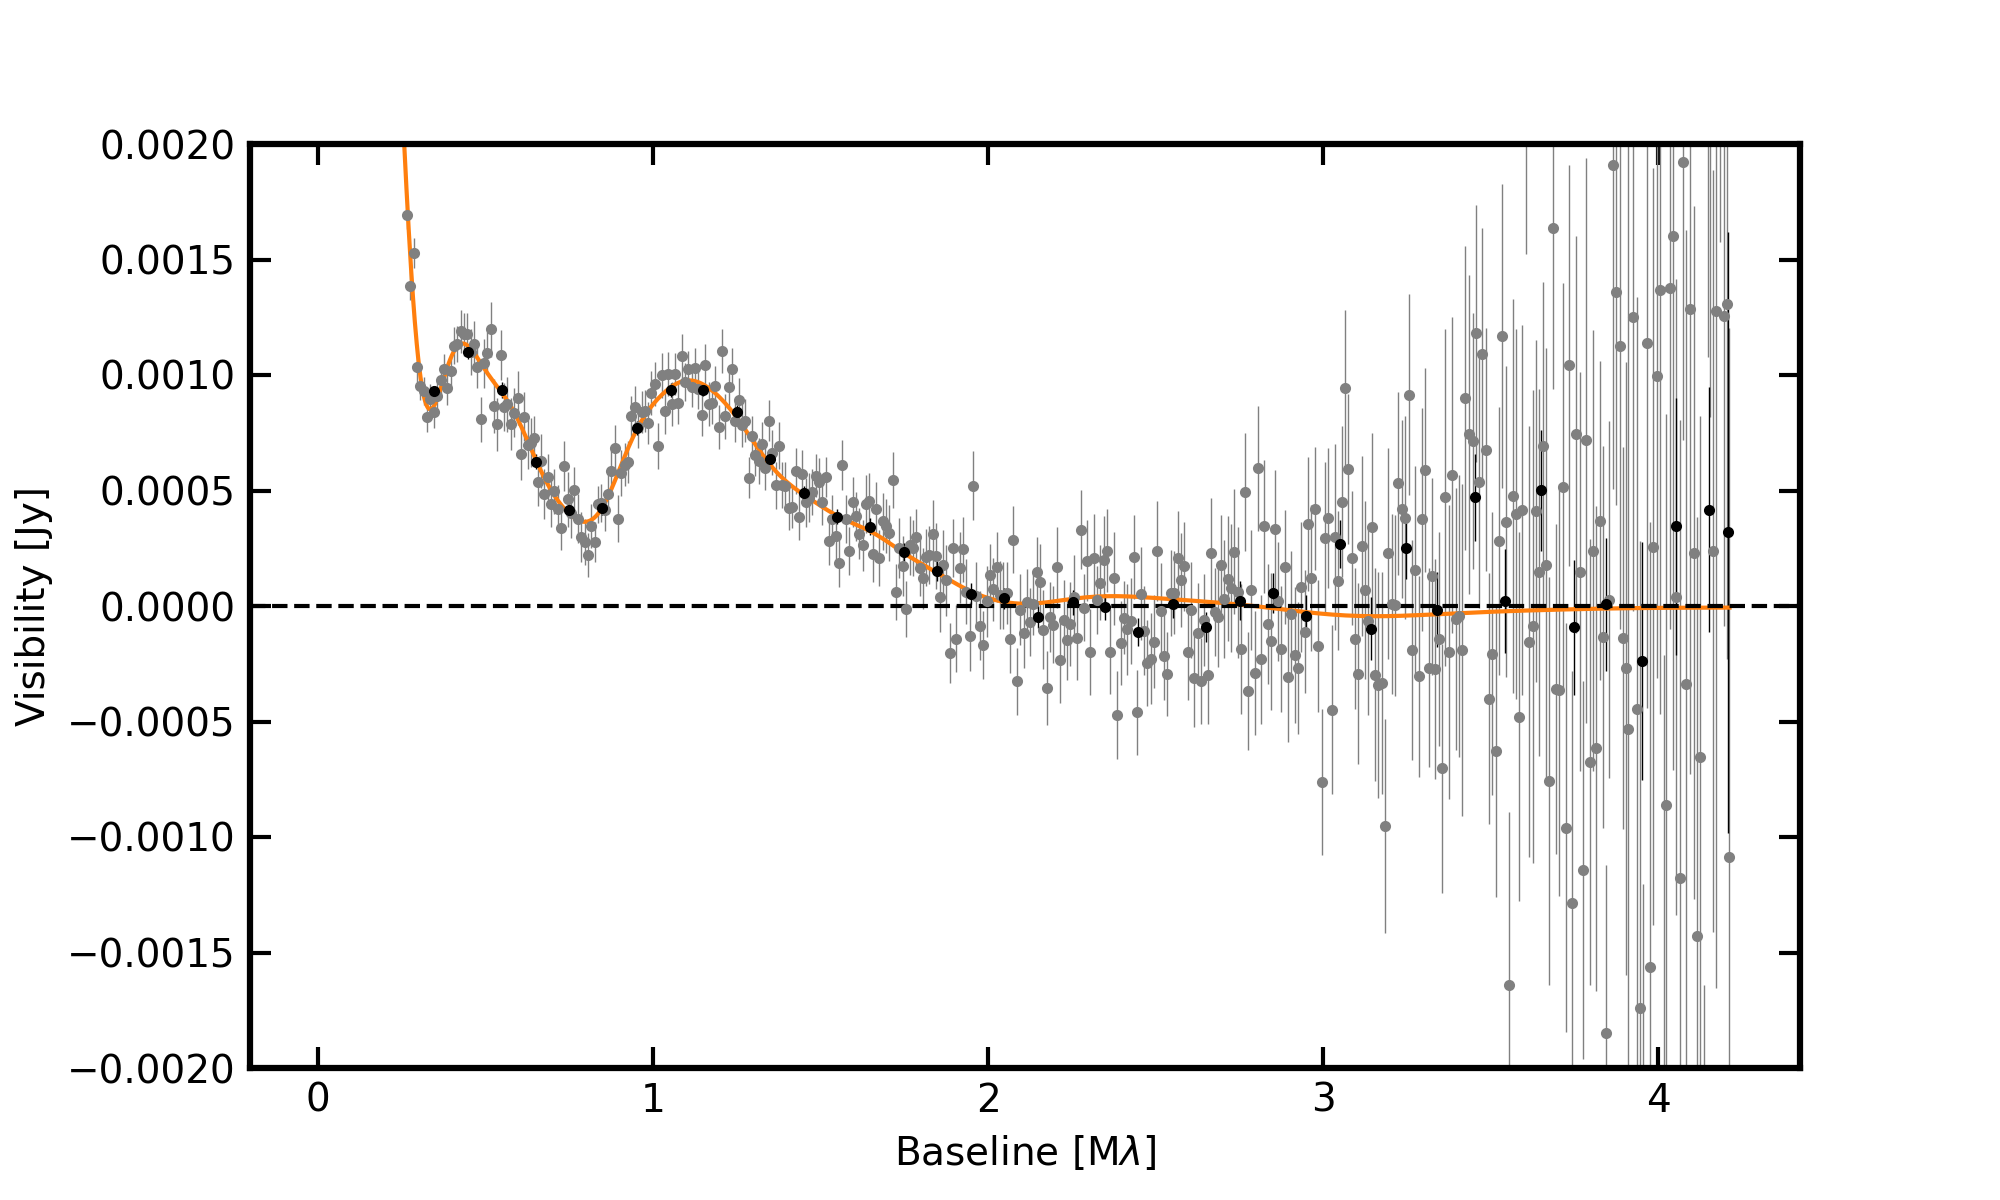

In [48]:
plt.figure(figsize=(10,6))

binned_vis = frank.utilities.UVDataBinner(np.hypot(up,vp), visp, w, 1e4)
plt.errorbar(binned_vis.uv/1e6, binned_vis.V.real, binned_vis.error.real, ls='none', lw=0.5, c='gray', marker='.')

binned_vis = frank.utilities.UVDataBinner(np.hypot(up,vp), visp, w, 1e5)
plt.errorbar(binned_vis.uv/1e6, binned_vis.V.real, binned_vis.error.real, ls='none', lw=0.5, c='k', marker='.')

qs = np.geomspace(np.hypot(up,vp).min(), np.hypot(up,vp).max(), 1000)
plt.semilogx(qs/1e6, sol_B3.predict_deprojected(qs), c='C1')

plt.axhline(0, ls='--', c='k')

plt.xlabel(r'Baseline [M$\lambda$]')
plt.ylabel(r'Visibility [Jy]')

plt.xscale('linear')

plt.ylim(-2e-3,+2e-3)

plt.savefig('./band3_pssub/band3_vis_fit_alpha{}_wsmooth{}_N{}_Rout{}.pdf'.format(alpha,w_smooth,N,Rmax),bbox_inches='tight')
plt.show()

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


<IPython.core.display.Javascript object>


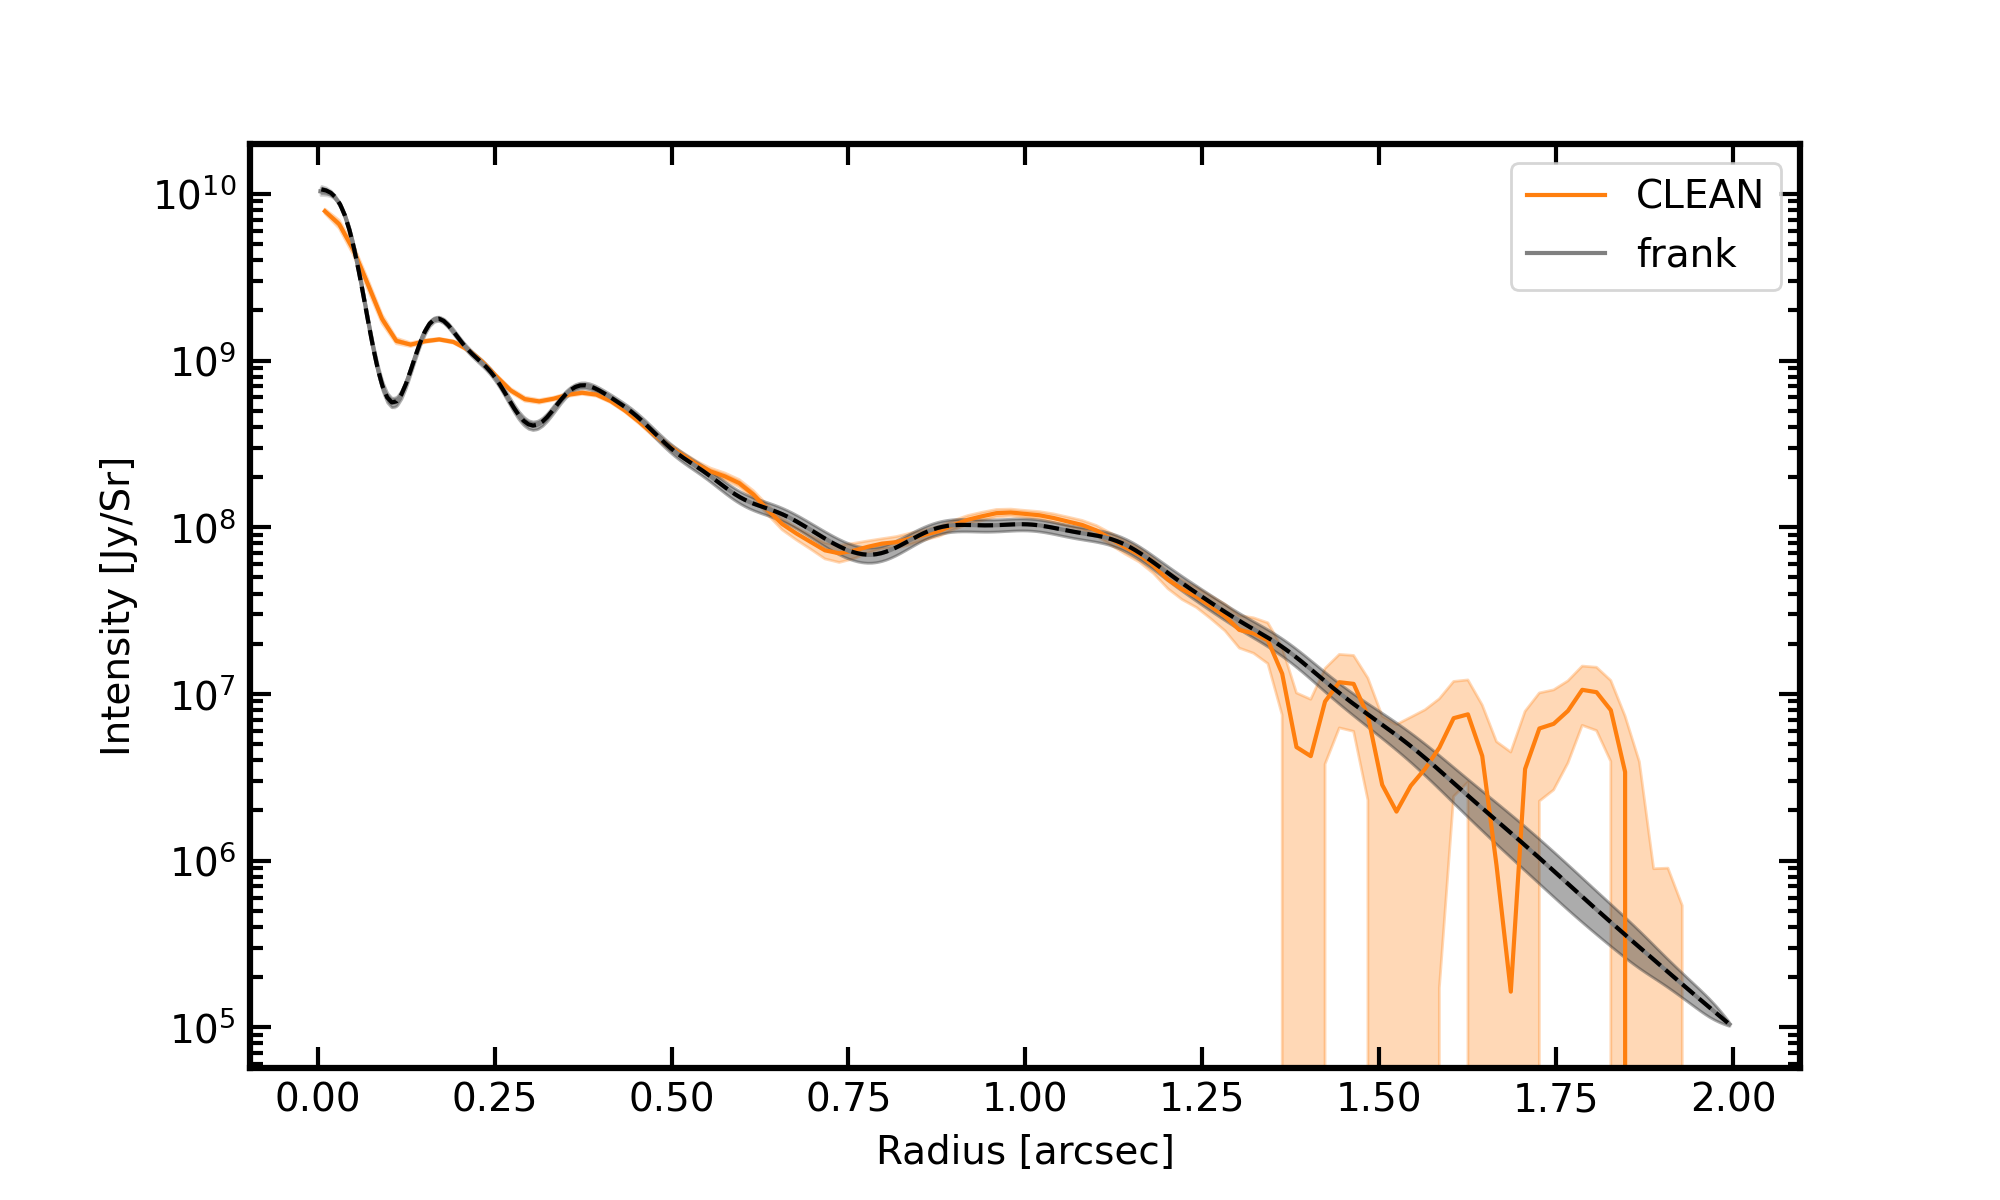

In [49]:
cube = imagecube('../../images_band3/CI_Tau_LB_0.5robust_1.0sigma.image.tt0.fits', FOV=4.)

x, y, dy = cube.radial_profile(inc=geom.inc, PA=geom.PA)

y_b  = _calculate_flux_jy_sr( y, cube.bmin, cube.bmaj)
dy_b = _calculate_flux_jy_sr(dy, cube.bmin, cube.bmaj)

plt.figure(figsize=(10,6))

plt.semilogy(x, y_b, c='C1', label='CLEAN')
plt.fill_between(x, y_b - dy_b, y_b + dy_b, color='C1', alpha=0.3)

plt.semilogy(sol_B3.r, sol_B3.I, c='gray', label='frank')
err = sol_B3.I*np.sqrt(np.exp(np.diag(sol_B3.covariance)) - 1.)
plt.fill_between(sol_B3.r, sol_B3.I - err, sol_B3.I + err, alpha=0.3, color='gray')

plt.xlabel('Radius [arcsec]')
plt.ylabel('Intensity [Jy/Sr]')

plt.legend()

xf, yf, dy_f = np.loadtxt('../frankfits_06-2023/band3/CI_Tau_B3_frank_profile_bestfit.dat',unpack=True,skiprows=1)

l, = plt.plot(xf, yf, ls='--', c='k')
plt.fill_between(xf, yf - dy_f, yf + dy_f, color=l.get_color(), alpha=0.2)

plt.savefig('./band3_pssub/band3_vis_profile_fit_alpha{}_wsmooth{}_N{}_Rout{}.pdf'.format(alpha,w_smooth,N,Rmax),bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


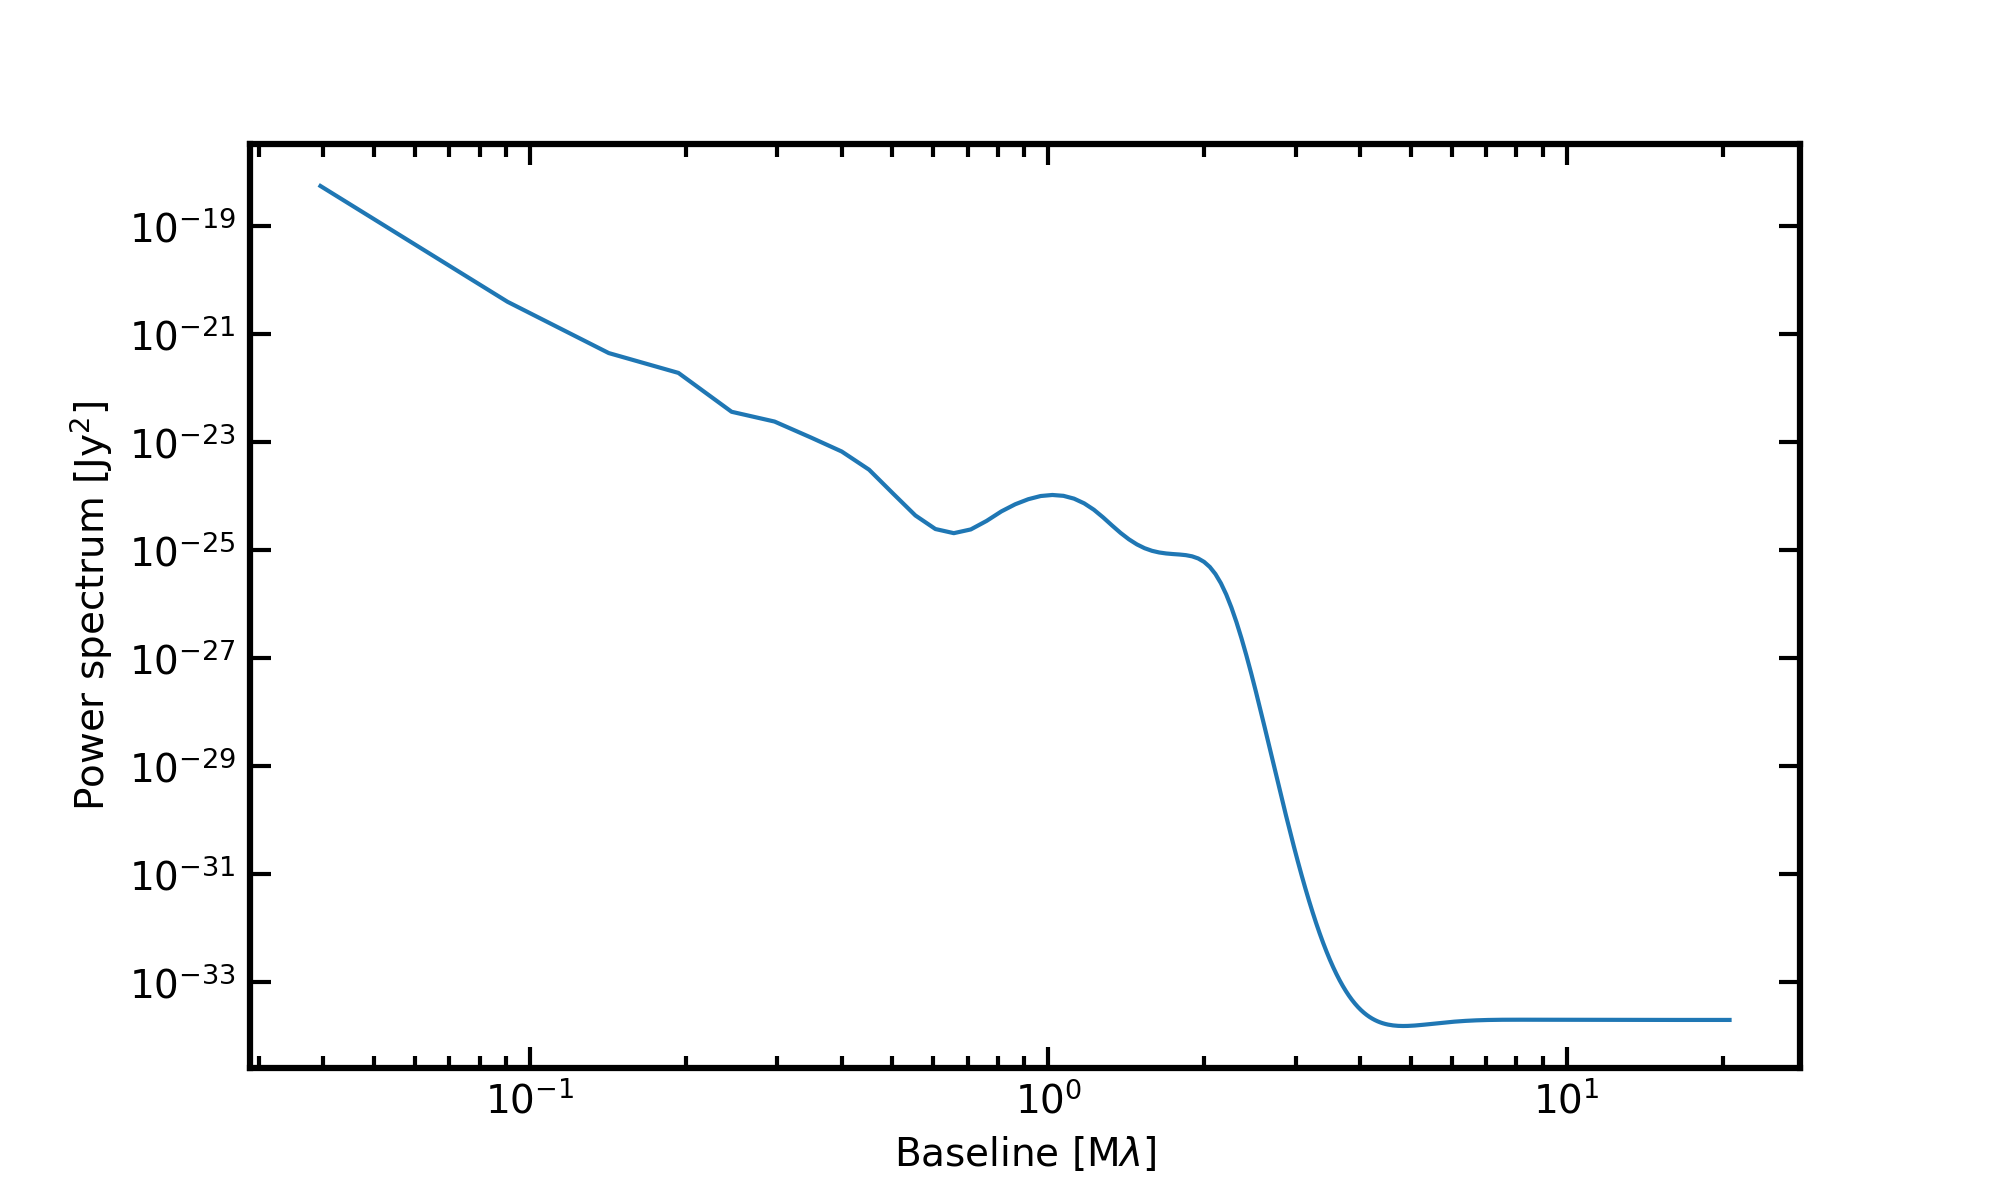

In [50]:
plt.figure(figsize=(10,6))

plt.loglog(sol_B3.q/1e6, sol_B3.power_spectrum)

plt.ylabel(r'Power spectrum [Jy$^2$]')
plt.xlabel(r'Baseline [M$\lambda$]')

plt.savefig('./band3_pssub/band3_pow_profile_fit_alpha{}_wsmooth{}_N{}_Rout{}.pdf'.format(alpha,w_smooth,N,Rmax),bbox_inches='tight')
plt.show()

In [51]:
frank.io.save_fit(
    u, v, vis, w, sol_B3, prefix='./band3_pssub/CI_Tau_B3', format='txt',
    save_solution       = True, 
    save_profile_fit    = True, 
    save_vis_fit        = True, 
    save_uvtables       = True,
    save_iteration_diag = True, 
    iteration_diag      = None,
)

  Saving fit results to ./band3_pssub/CI_Tau_B3*
    Saving fit and residual UVTables. N.B.: These will be of comparable size to your input UVTable


In [52]:
np.savetxt(
    './band3_pssub/CI_Tau_B3_frank_profile_bestfit.dat',
    np.array([sol_B3.r, sol_B3.I, err]).T,
    header='r [arcsec]\tI [Jy/sr]\tI_uncer [Jy/sr]'
)

np.savetxt(
    './band3_pssub/CI_Tau_B3_frank_visibilities_bestfit.dat',
    np.array([qs, sol_B3.predict_deprojected(qs)]).T,
    header='Deprojected baseline [lam]\tVisibility [Jy]'
)

VLA band Ka:

In [53]:
UVTABLE = '../ps_subtraction/bandKa/uvtable_CI_Tau_Ka_PSsub.txt'

In [54]:
u, v, vis, w = frank.io.load_uvtable(UVTABLE)

  Loading UVTable


In [55]:
geom = frank.geometry.FitGeometryGaussian(inc_pa=(49.24,11.28))
geom.fit(u, v, vis, w)

    Fitting Gaussian to determine geometry (not fitting for inc or PA)


In [56]:
print('Fitted geometry: inc  = {:.2f} deg,\n\t\t PA   = {:.2f} deg,\n\t\t' 
      ' dRA  = {:.2e} mas,\n\t\t dDec = {:.2e} mas'.format(geom.inc, 
                                                           geom.PA,
                                                           geom.dRA*1e3,
                                                           geom.dDec*1e3))

Fitted geometry: inc  = 49.24 deg,
		 PA   = 11.28 deg,
		 dRA  = 1.19e-05 mas,
		 dDec = -1.06e-05 mas


In [57]:
geom = frank.geometry.FixedGeometry(49.24, 11.28, -1.21e-06, -2.00e-07)
#use the same deprojection params of ../ps_subtraction/bandKa/psKa.ipynb

In [58]:
up, vp, visp = geom.apply_correction(u, v, vis)

In [59]:
# Re-estimate weights:
# wp = frank.utilities.estimate_weights(up, vp, vis, use_median=True)

<IPython.core.display.Javascript object>


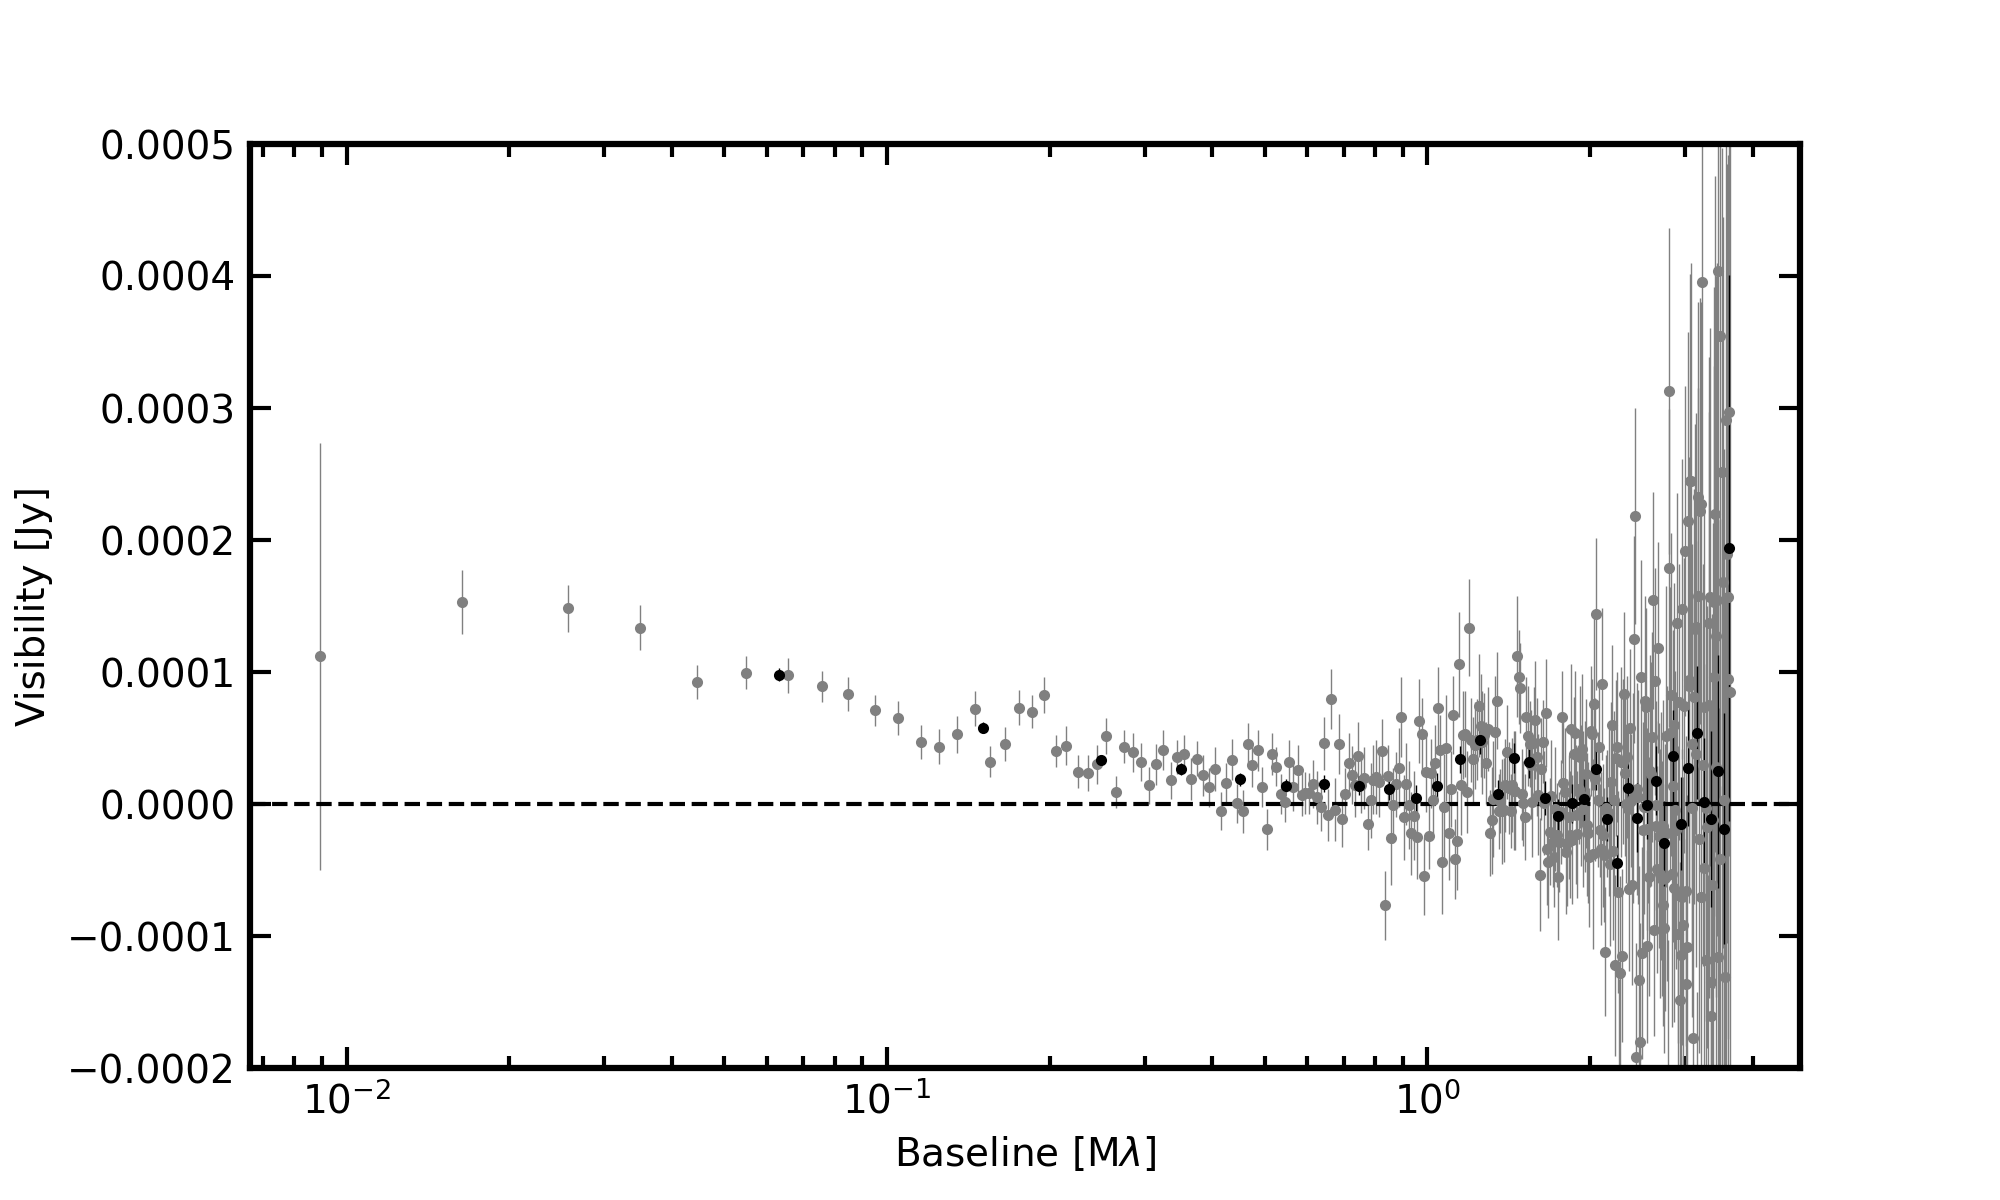

In [60]:
plt.figure(figsize=(10,6))

binned_vis = frank.utilities.UVDataBinner(np.hypot(up,vp), visp, w, 1e4)
plt.errorbar(binned_vis.uv/1e6, binned_vis.V.real, binned_vis.error.real, ls='none', lw=0.5, c='gray', marker='.')

binned_vis = frank.utilities.UVDataBinner(np.hypot(up,vp), visp, w, 1e5)
plt.errorbar(binned_vis.uv/1e6, binned_vis.V.real, binned_vis.error.real, ls='none', lw=0.5, c='k', marker='.')

plt.axhline(0, ls='--', c='k')

plt.xlabel(r'Baseline [M$\lambda$]')
plt.ylabel(r'Visibility [Jy]')

plt.xscale('log')

plt.ylim(-2e-4,+5e-4)

plt.savefig('./bandKa_pssub/bandKa_vis.pdf',bbox_inches='tight')
plt.show()

In [61]:
N        = 300
Rmax     = 2.00
alpha    = 1.05
w_smooth = 1e+0
method   = 'LogNormal'

In [62]:
FF = frank.radial_fitters.FrankFitter(
    N              = N, 
    Rmax           = Rmax, 
    geometry       = geom, 
    method         = method,
    alpha          = alpha, 
    weights_smooth = w_smooth, 
    max_iter       = 4000
)

sol_Ka = FF.fit(u, v, vis, w)
#steps 1731 alpha 1.05, wsmooth 1e+0, 300

  Assuming an optically thick model (the default): Scaling the total flux to account for the source inclination
  Fitting for brightness profile using FrankFitter: LogNormal method
    Building visibility matrices M and j


    FrankFitter iteration 1731

    Convergence criterion met at iteration 1731


<IPython.core.display.Javascript object>


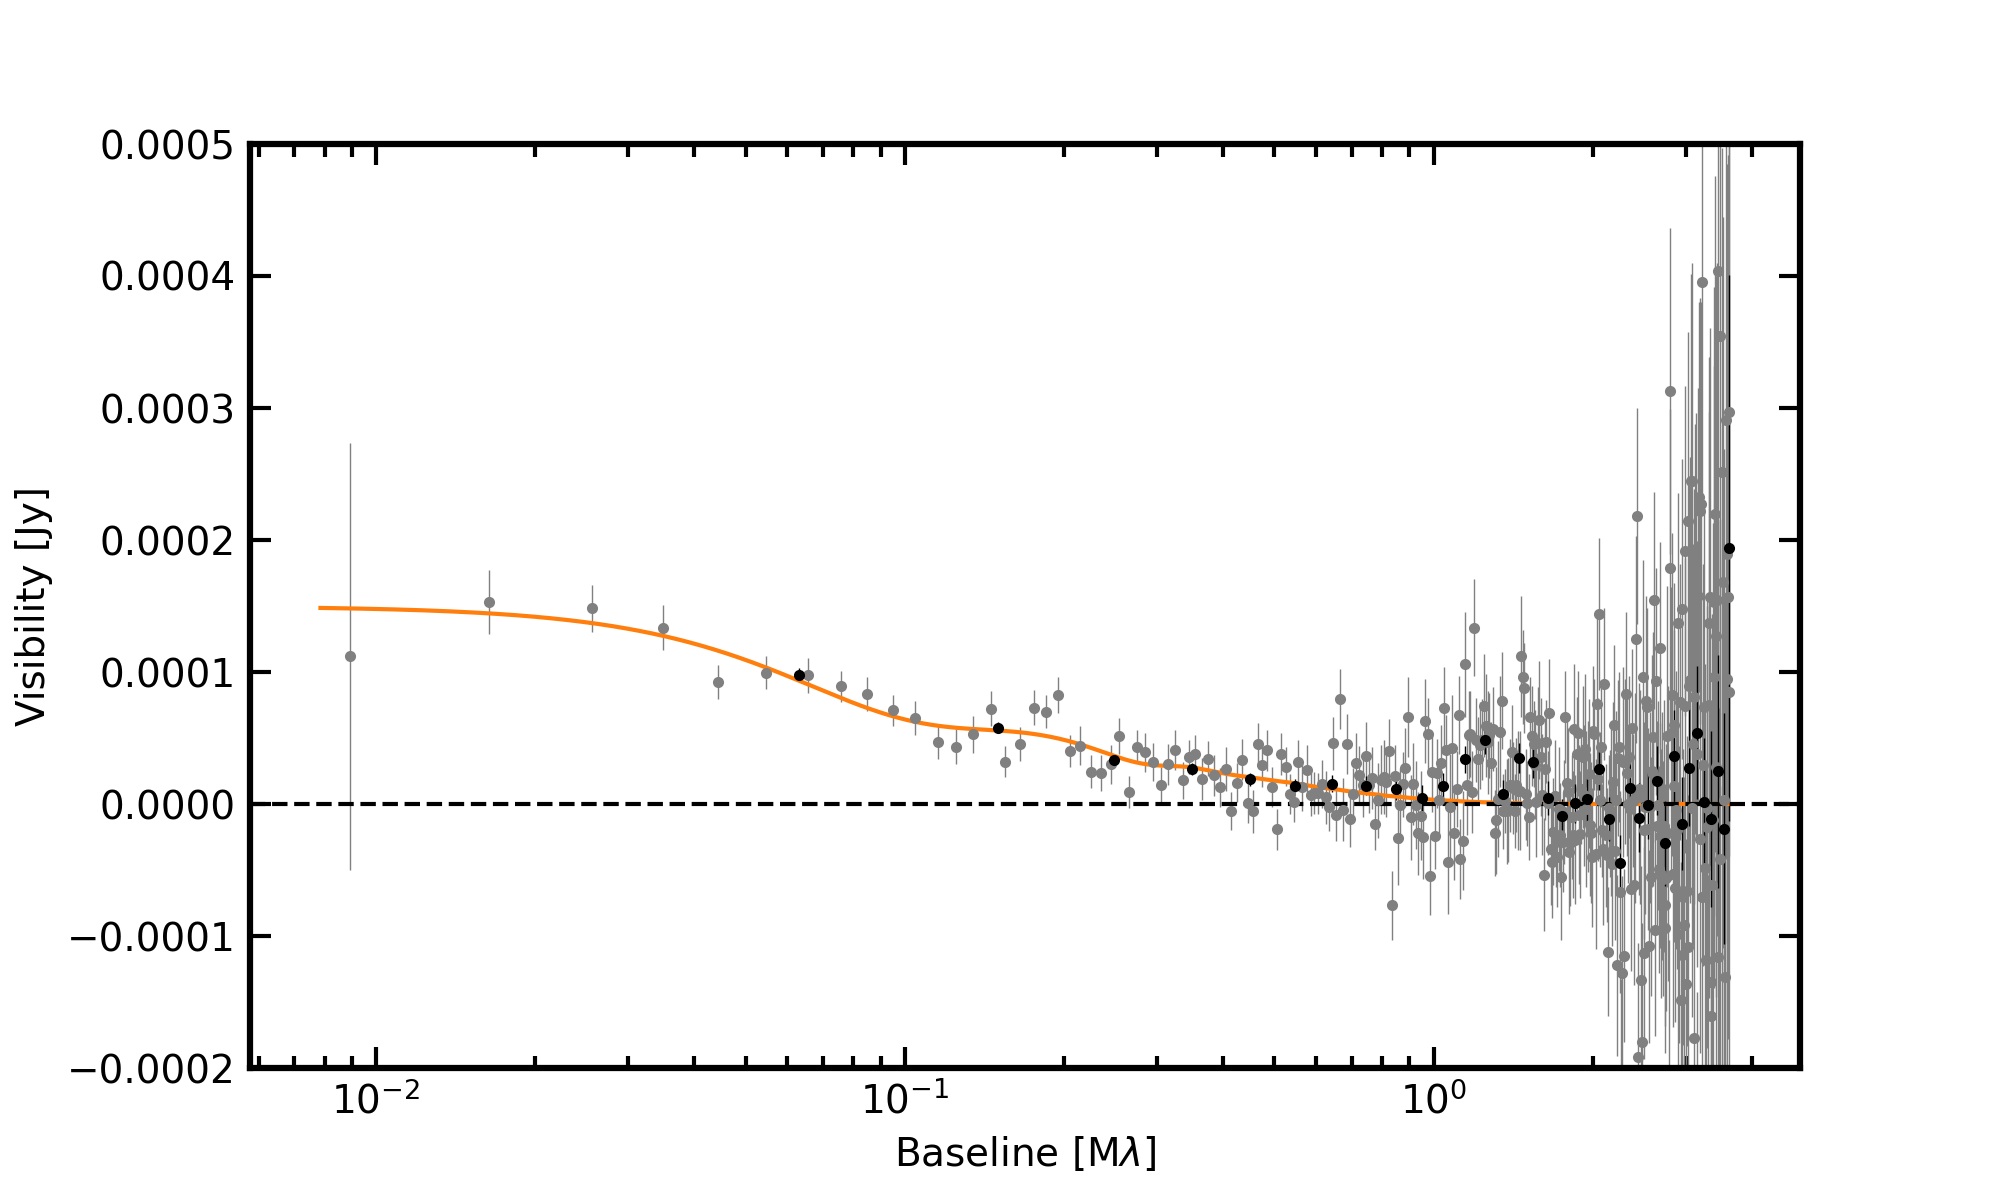

In [63]:
plt.figure(figsize=(10,6))

binned_vis = frank.utilities.UVDataBinner(np.hypot(up,vp), visp, w, 1e4)
plt.errorbar(binned_vis.uv/1e6, binned_vis.V.real, binned_vis.error.real, ls='none', lw=0.5, c='gray', marker='.')

binned_vis = frank.utilities.UVDataBinner(np.hypot(up,vp), visp, w, 1e5)
plt.errorbar(binned_vis.uv/1e6, binned_vis.V.real, binned_vis.error.real, ls='none', lw=0.5, c='k', marker='.')

qs = np.geomspace(np.hypot(up,vp).min(), np.hypot(up,vp).max(), 1000)
plt.semilogx(qs/1e6, sol_Ka.predict_deprojected(qs), c='C1')

plt.axhline(0, ls='--', c='k')

plt.xlabel(r'Baseline [M$\lambda$]')
plt.ylabel(r'Visibility [Jy]')

# plt.xscale('linear')

plt.ylim(-2e-4,+5e-4)

plt.savefig('./bandKa_pssub/bandKa_vis_fit_alpha{}_wsmooth{}_N{}_Rout{}.pdf'.format(alpha,w_smooth,N,Rmax),bbox_inches='tight')
plt.show()

	 Reverting to standard azimuthal averaging; will ignore `unit` argument.


<IPython.core.display.Javascript object>


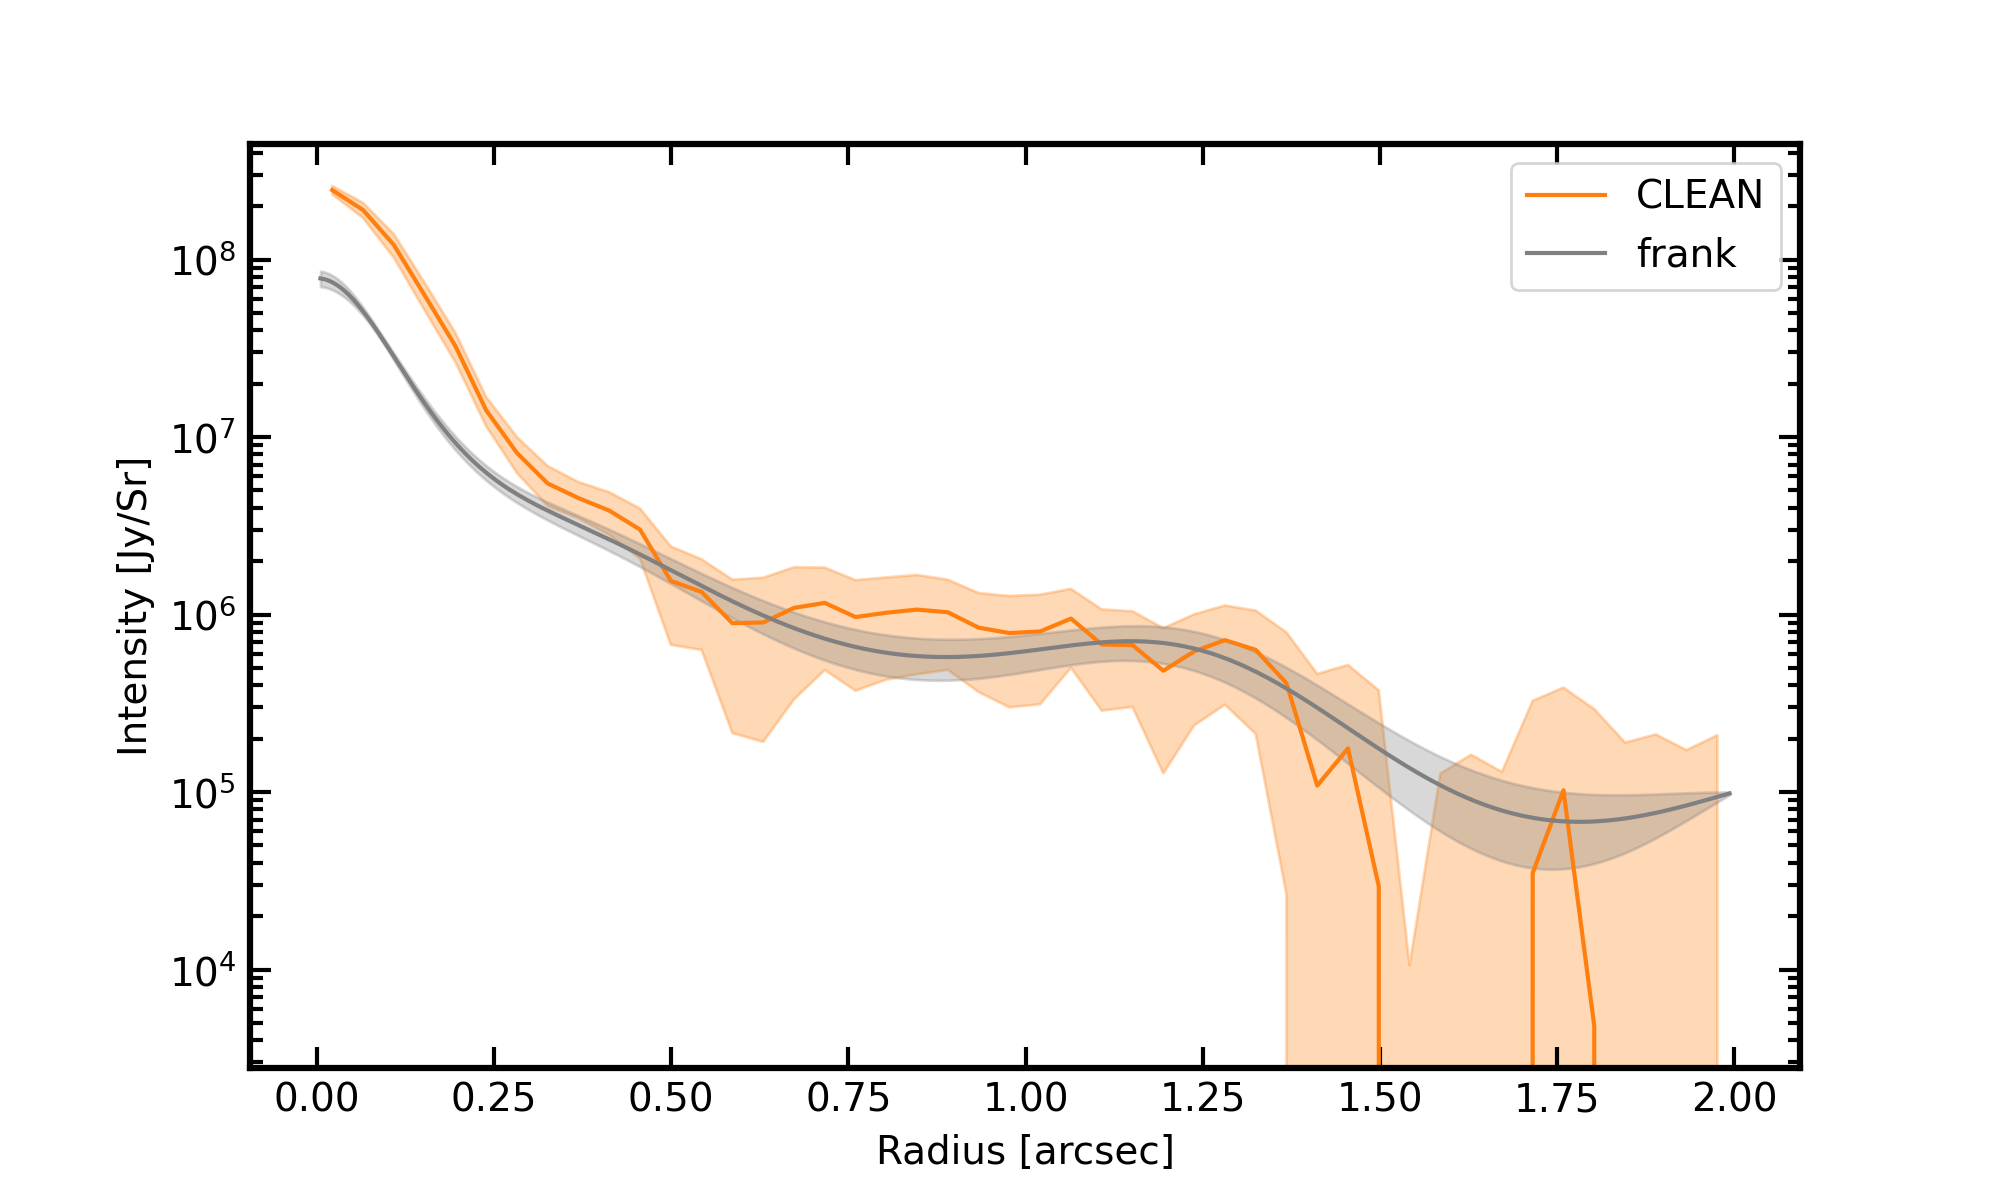

In [64]:
cube = imagecube('../../images_VLA/images_bandKa/CITau_VLA_Ka_Combined_ConfAB_selfcal_ave_1ch_60s_1.5robust_1.0sigma.image.tt0.fits', FOV=4.)

x, y, dy = cube.radial_profile(inc=geom.inc, PA=geom.PA)

y_b  = _calculate_flux_jy_sr( y, cube.bmin, cube.bmaj)
dy_b = _calculate_flux_jy_sr(dy, cube.bmin, cube.bmaj)

plt.figure(figsize=(10,6))

plt.semilogy(x, y_b, c='C1', label='CLEAN')
plt.fill_between(x, y_b - dy_b, y_b + dy_b, color='C1', alpha=0.3)

plt.semilogy(sol_Ka.r, sol_Ka.I, c='gray', label='frank')
err = sol_Ka.I*np.sqrt(np.exp(np.diag(sol_Ka.covariance)) - 1.)
plt.fill_between(sol_Ka.r, sol_Ka.I - err, sol_Ka.I + err, alpha=0.3, color='gray')

plt.xlabel('Radius [arcsec]')
plt.ylabel('Intensity [Jy/Sr]')

plt.legend()

plt.savefig('./bandKa_pssub/bandKa_vis_profile_fit_alpha{}_wsmooth{}_N{}_Rout{}.pdf'.format(alpha,w_smooth,N,Rmax),bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


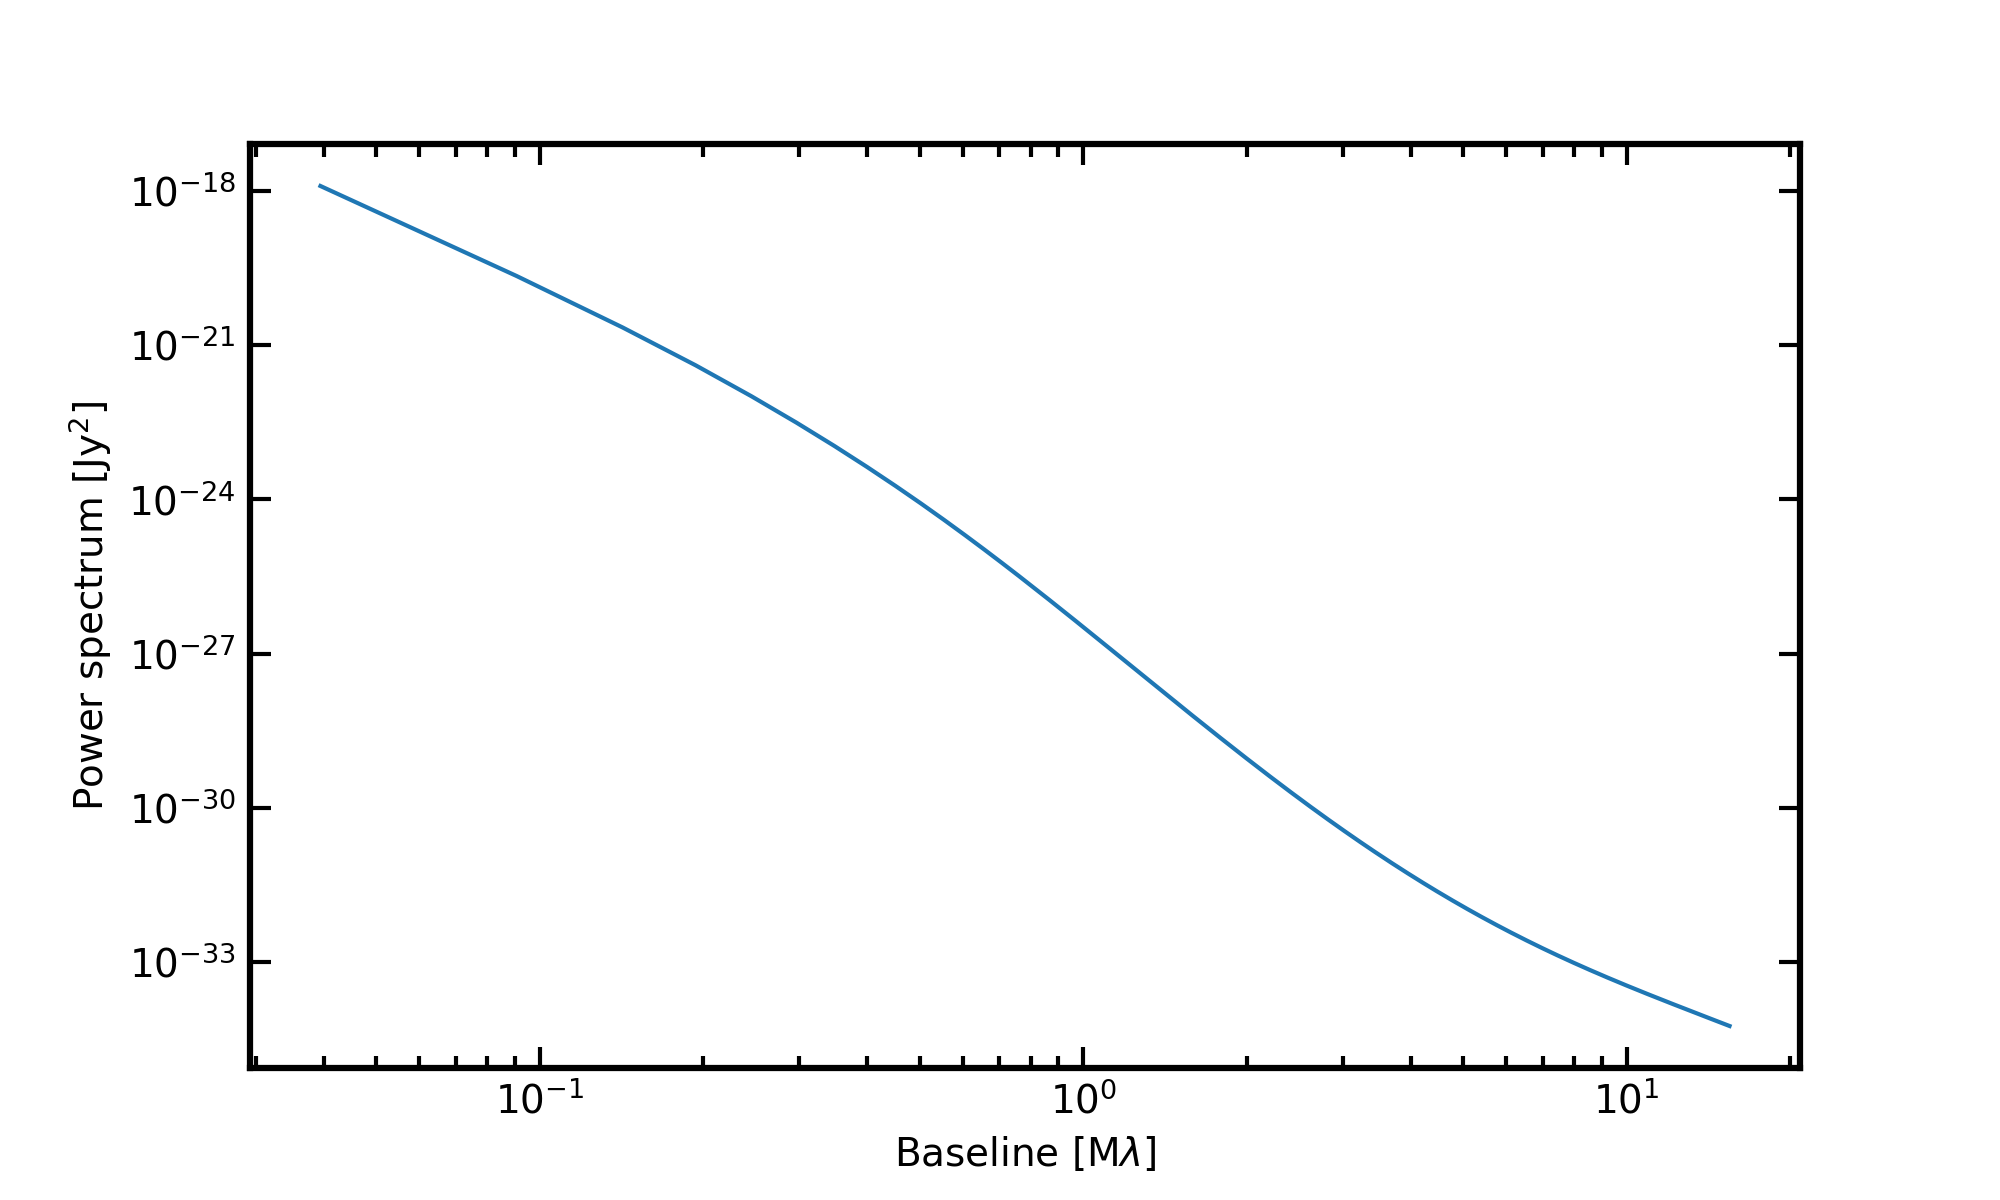

In [65]:
plt.figure(figsize=(10,6))

plt.loglog(sol_Ka.q/1e6, sol_Ka.power_spectrum)

plt.ylabel(r'Power spectrum [Jy$^2$]')
plt.xlabel(r'Baseline [M$\lambda$]')

plt.savefig('./bandKa_pssub/bandKa_pow_profile_fit_alpha{}_wsmooth{}_N{}_Rout{}.pdf'.format(alpha,w_smooth,N,Rmax),bbox_inches='tight')
plt.show()

In [66]:
frank.io.save_fit(
    u, v, vis, w, sol_Ka, prefix='./bandKa_pssub/CI_Tau_Ka', format='txt',
    save_solution       = True, 
    save_profile_fit    = True, 
    save_vis_fit        = True, 
    save_uvtables       = True,
    save_iteration_diag = True, 
    iteration_diag      = None,
)

  Saving fit results to ./bandKa_pssub/CI_Tau_Ka*
    Saving fit and residual UVTables. N.B.: These will be of comparable size to your input UVTable


In [67]:
np.savetxt(
    './bandKa_pssub/CI_Tau_Ka_frank_profile_bestfit.dat',
    np.array([sol_Ka.r, sol_Ka.I, err]).T,
    header='r [arcsec]\tI [Jy/sr]\tI_uncer [Jy/sr]'
)

np.savetxt(
    './bandKa_pssub/CI_Tau_Ka_frank_visibilities_bestfit.dat',
    np.array([qs, sol_Ka.predict_deprojected(qs)]).T,
    header='Deprojected baseline [lam]\tVisibility [Jy]'
)